In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import arviz as az

import pymc as pm
import numpy as np
import preliz as pz

In [2]:
az.style.use(["arviz-white"])
plt.rc('font', family="arial")
plt.rc('font', size=12)
plt.rc('figure', dpi=300)

## Physical model

$$
y_i = y_{i-1} e^{(-\lambda)} + r\beta \mathbf{1}_{((r_i + r_{i-1}) > t)} - T_i  γ
$$

In [3]:
name = "NUEVA"

df = pd.read_excel("19-22_DataModelo_v3.xlsx", sheet_name=name)

time = df['Fecha'].values
rain = df[f'SumaDifPluvio(mm)_{str.title(name)}'].values
vol = df[f"VolumenRep{str.title(name)}_m3"].values
tma = df['TempMediaAire_Celsius'].values + 273.15
vol_sd = df['SDvol_m3'].values


In [4]:
from pytensor.compile.ops import as_op
import pytensor.tensor as at
from numba import njit


@as_op(itypes=[at.dvector, at.dvector, at.dvector, at.dscalar, at.dscalar, at.dscalar, at.dscalar], otypes=[at.dvector])
def sim(vol, rain, tma, λ, τ, β, γ):
    return _sim(vol, rain, tma, λ, τ, β, γ)

@njit
def _sim(vol, rain, tma, λ, τ, β, γ):
    prev = vol[0]
    vols = np.zeros_like(vol)
    vols[0] = prev
    for i in range(1, len(vol)):
        if (rain[i] + rain[i-1]) > τ:
            influx = rain[i] * β
        else:
            influx = 0.
        prev = max(0, (prev - prev*np.exp(-λ) + influx - tma[i] * γ))
        vols[i] = prev
    return vols

In [5]:
names = ("CASA", "BH", "NUEVA", "FABIAN", "PEDRO", "MIGUEL")
models = {}
idatas = {}
vols = {}
times = {}

for name in names:
    df = pd.read_excel("19-22_DataModelo_v3.xlsx", sheet_name=name)

    time = df['Fecha'].values
    rain = df[f'SumaDifPluvio(mm)_{str.title(name)}'].values
    vol = df[f"VolumenRep{str.title(name)}_m3"].values
    tma = df['TempMediaAire_Celsius'].values + 273.15


    with pm.Model() as model:
        β = pm.HalfNormal("β", 100)
        γ = pm.HalfNormal("γ", 1)
        λ = pm.HalfNormal("λ", 20)
        τ = pm.HalfNormal("τ", 20)
        ϵ = pm.HalfNormal("ϵ", 1000)
        
        mu = sim(at.as_tensor(vol), at.as_tensor(rain), at.as_tensor(tma), λ, τ, β, γ)

        y_obs = pm.TruncatedNormal("y_obs", mu=mu, sigma=ϵ, lower=0, observed=vol)

        # By default SMC starts sampling from the prior distribution and then moves
        # closer and closer into the posterior distribution. But is usually a good choice.
        # But in theory we could start sampling from any distribution we want.
        # We were having sampling issues with a single SMC run, so we run it once
        # and use the results as a starting point for a second run.
        idata = pm.sample_smc(3000,
                             compute_convergence_checks=False,
                             random_seed=2045)
        
        start = {f"{vn}_log__": np.log(idata.posterior[vn].mean("chain").values) for vn in
                 ["β", "γ", "λ", "τ", "ϵ"]}

        idata = pm.sample_smc(3000,  start=start,
                        compute_convergence_checks=False,
                        random_seed=2045)

        models[name] = model
        idatas[name] = idata
        vols[name] = vol
        times[name] = time


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/home/osvaldo/proyectos/00_BM/arviz/arviz/data/base.py:221: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/home/osvaldo/proyectos/00_BM/arviz/arviz/data/base.py:221: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/home/osvaldo/proyectos/00_BM/arviz/arviz/data/base.py:221: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/home/osvaldo/proyectos/00_BM/arviz/arviz/data/base.py:221: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/home/osvaldo/proyectos/00_BM/arviz/arviz/data/base.py:221: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/home/osvaldo/proyectos/00_BM/arviz/arviz/data/base.py:221: UserWarning: More chains (4) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 1013 (\N{GREEK LUNATE EPSILON SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


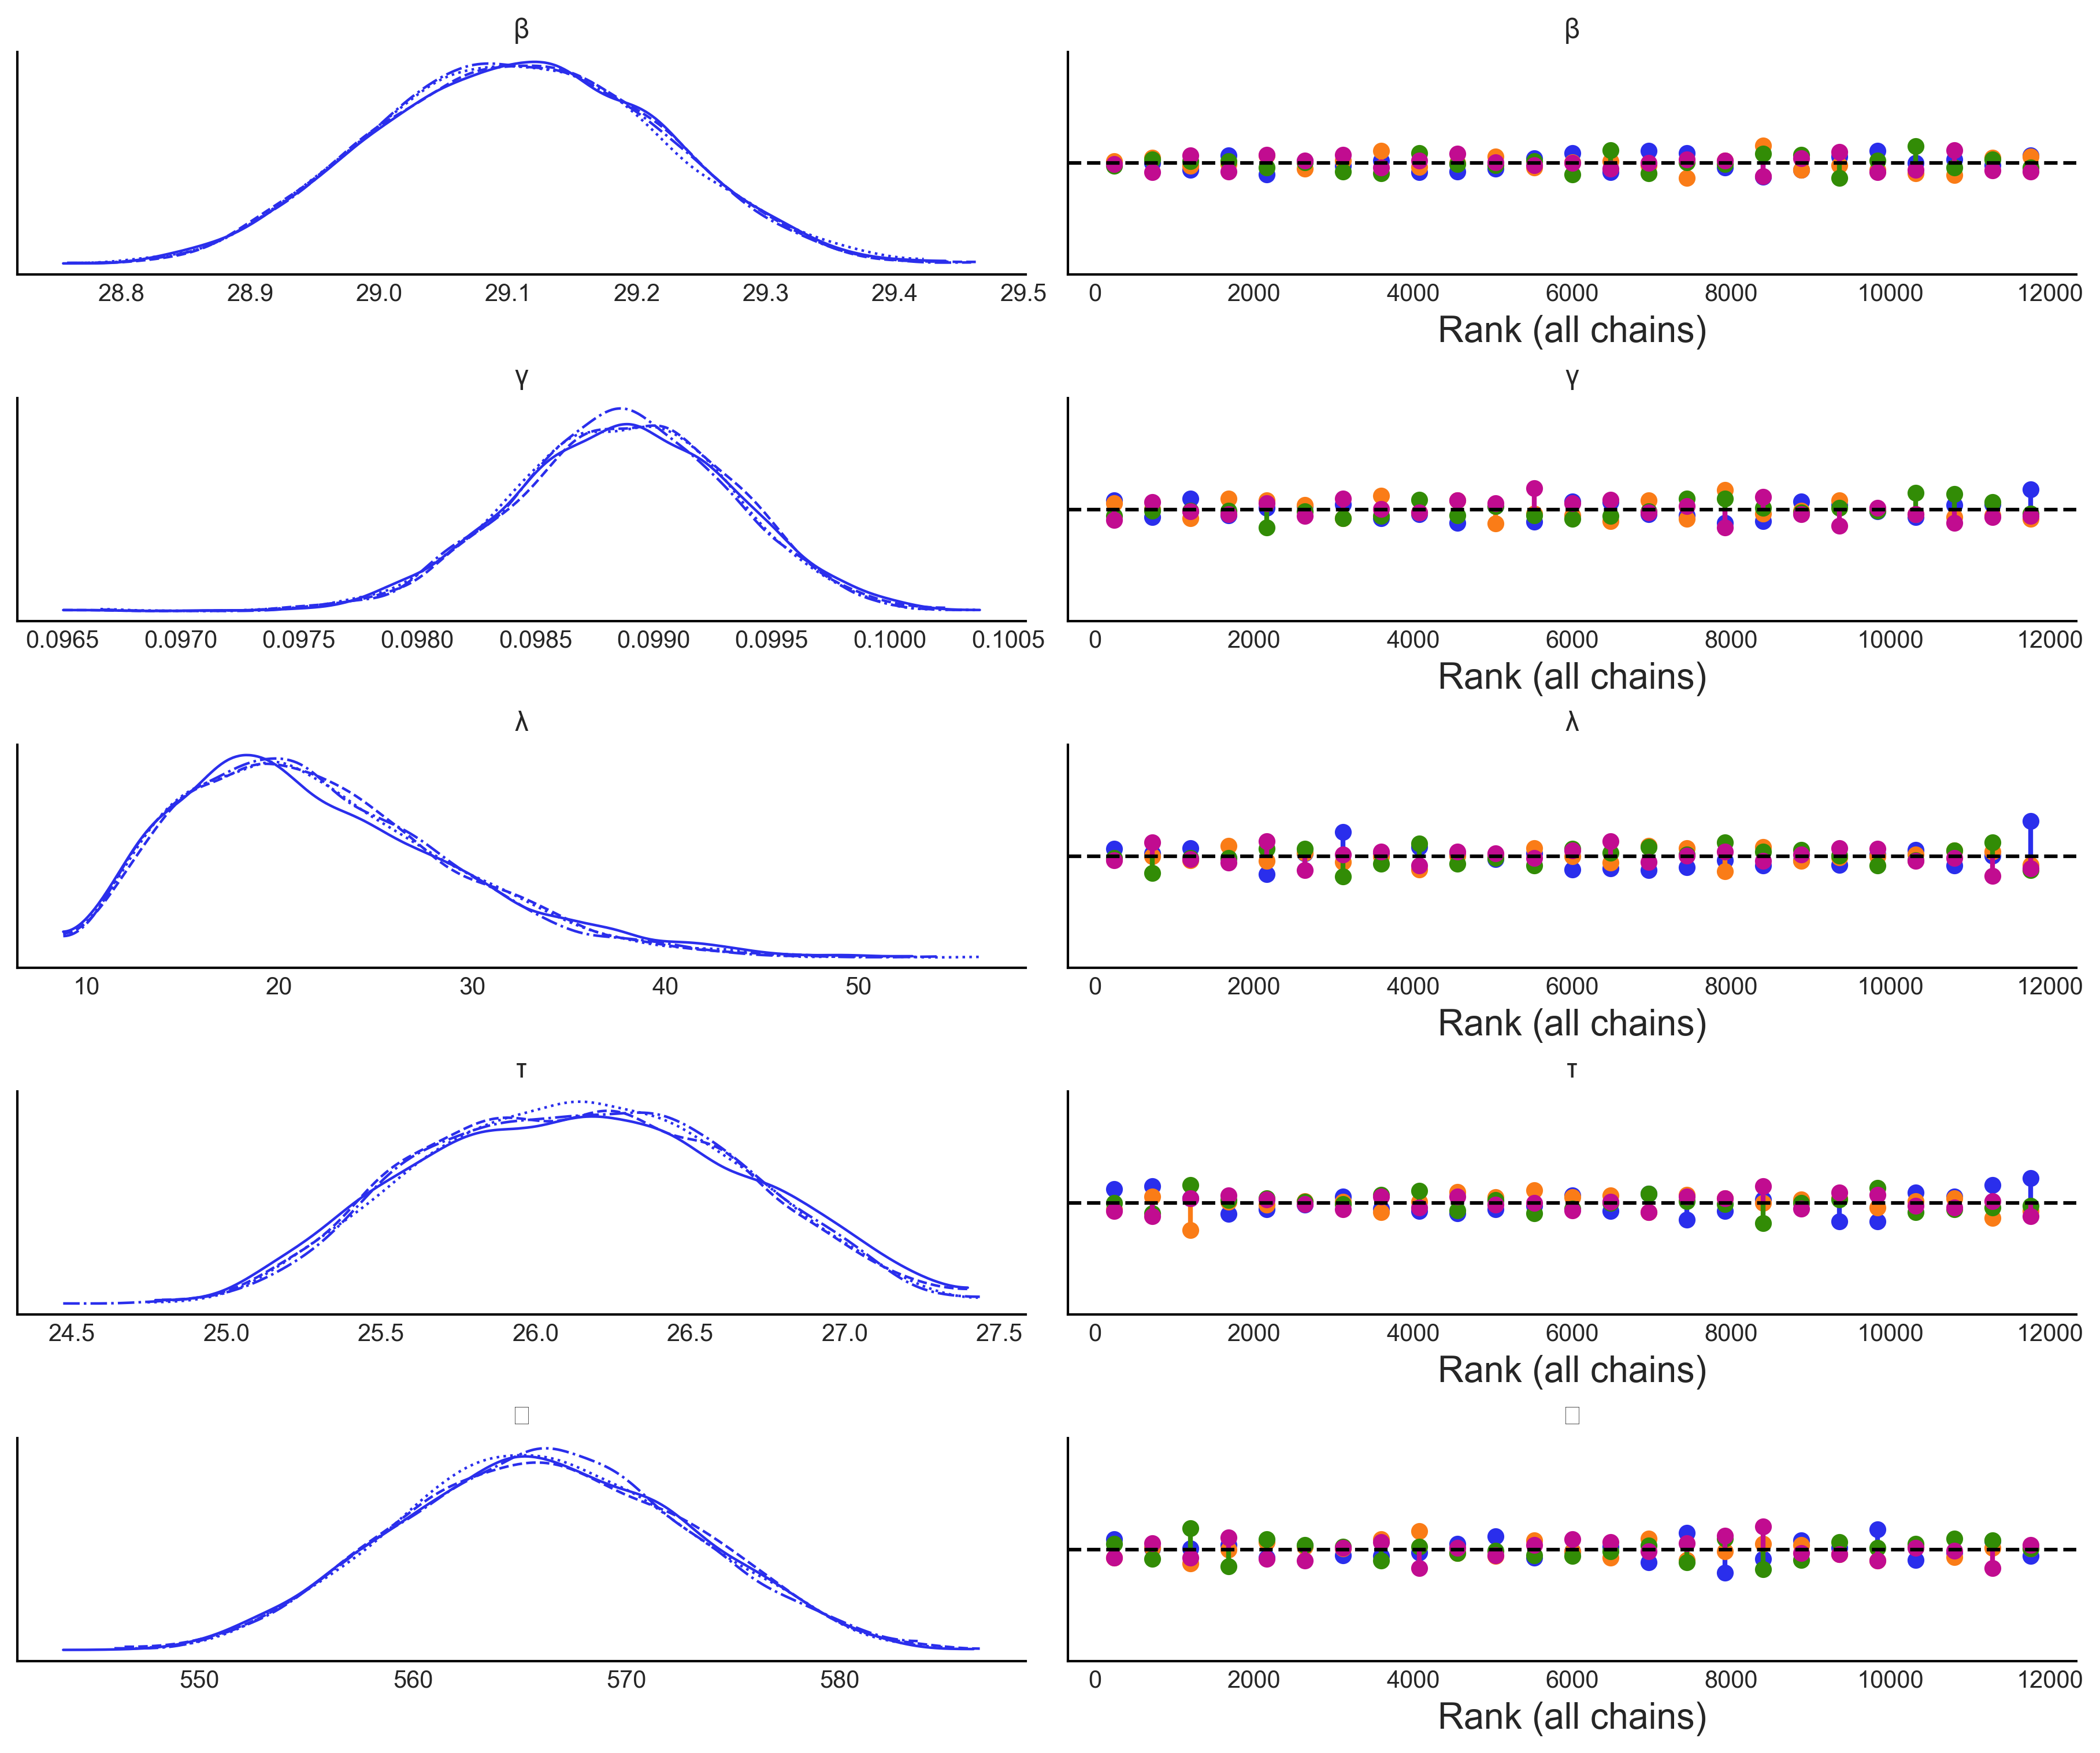

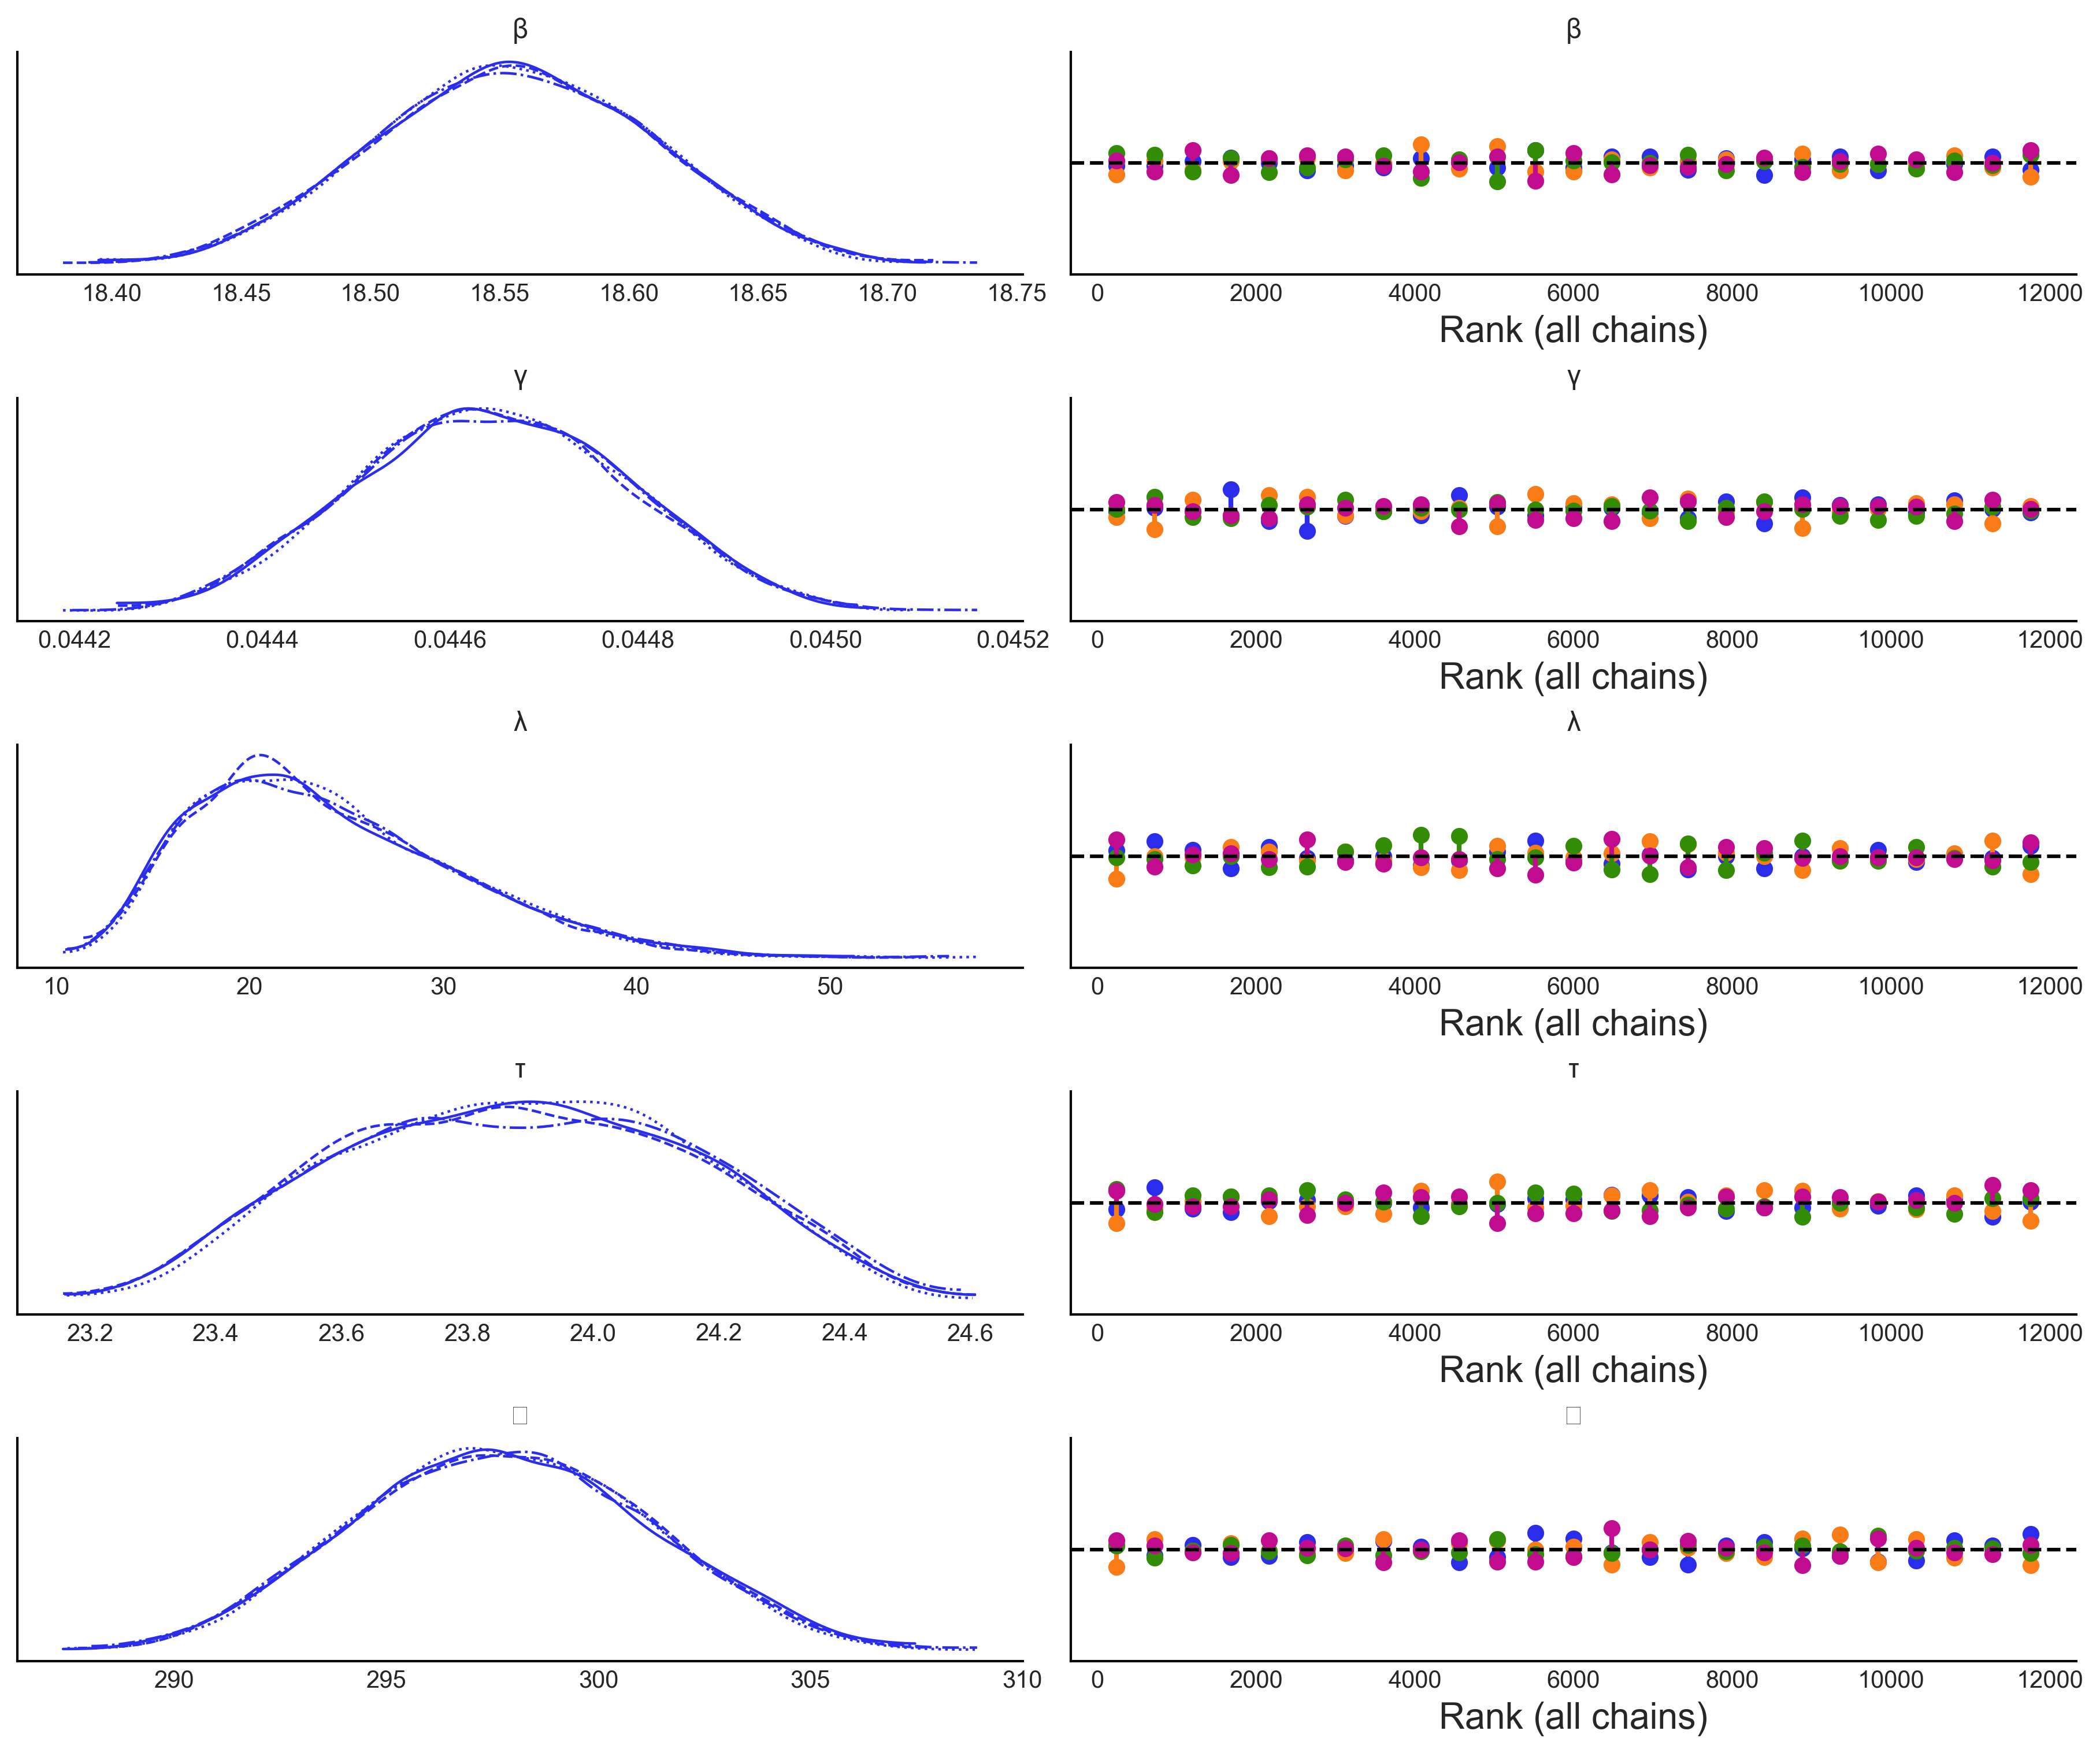

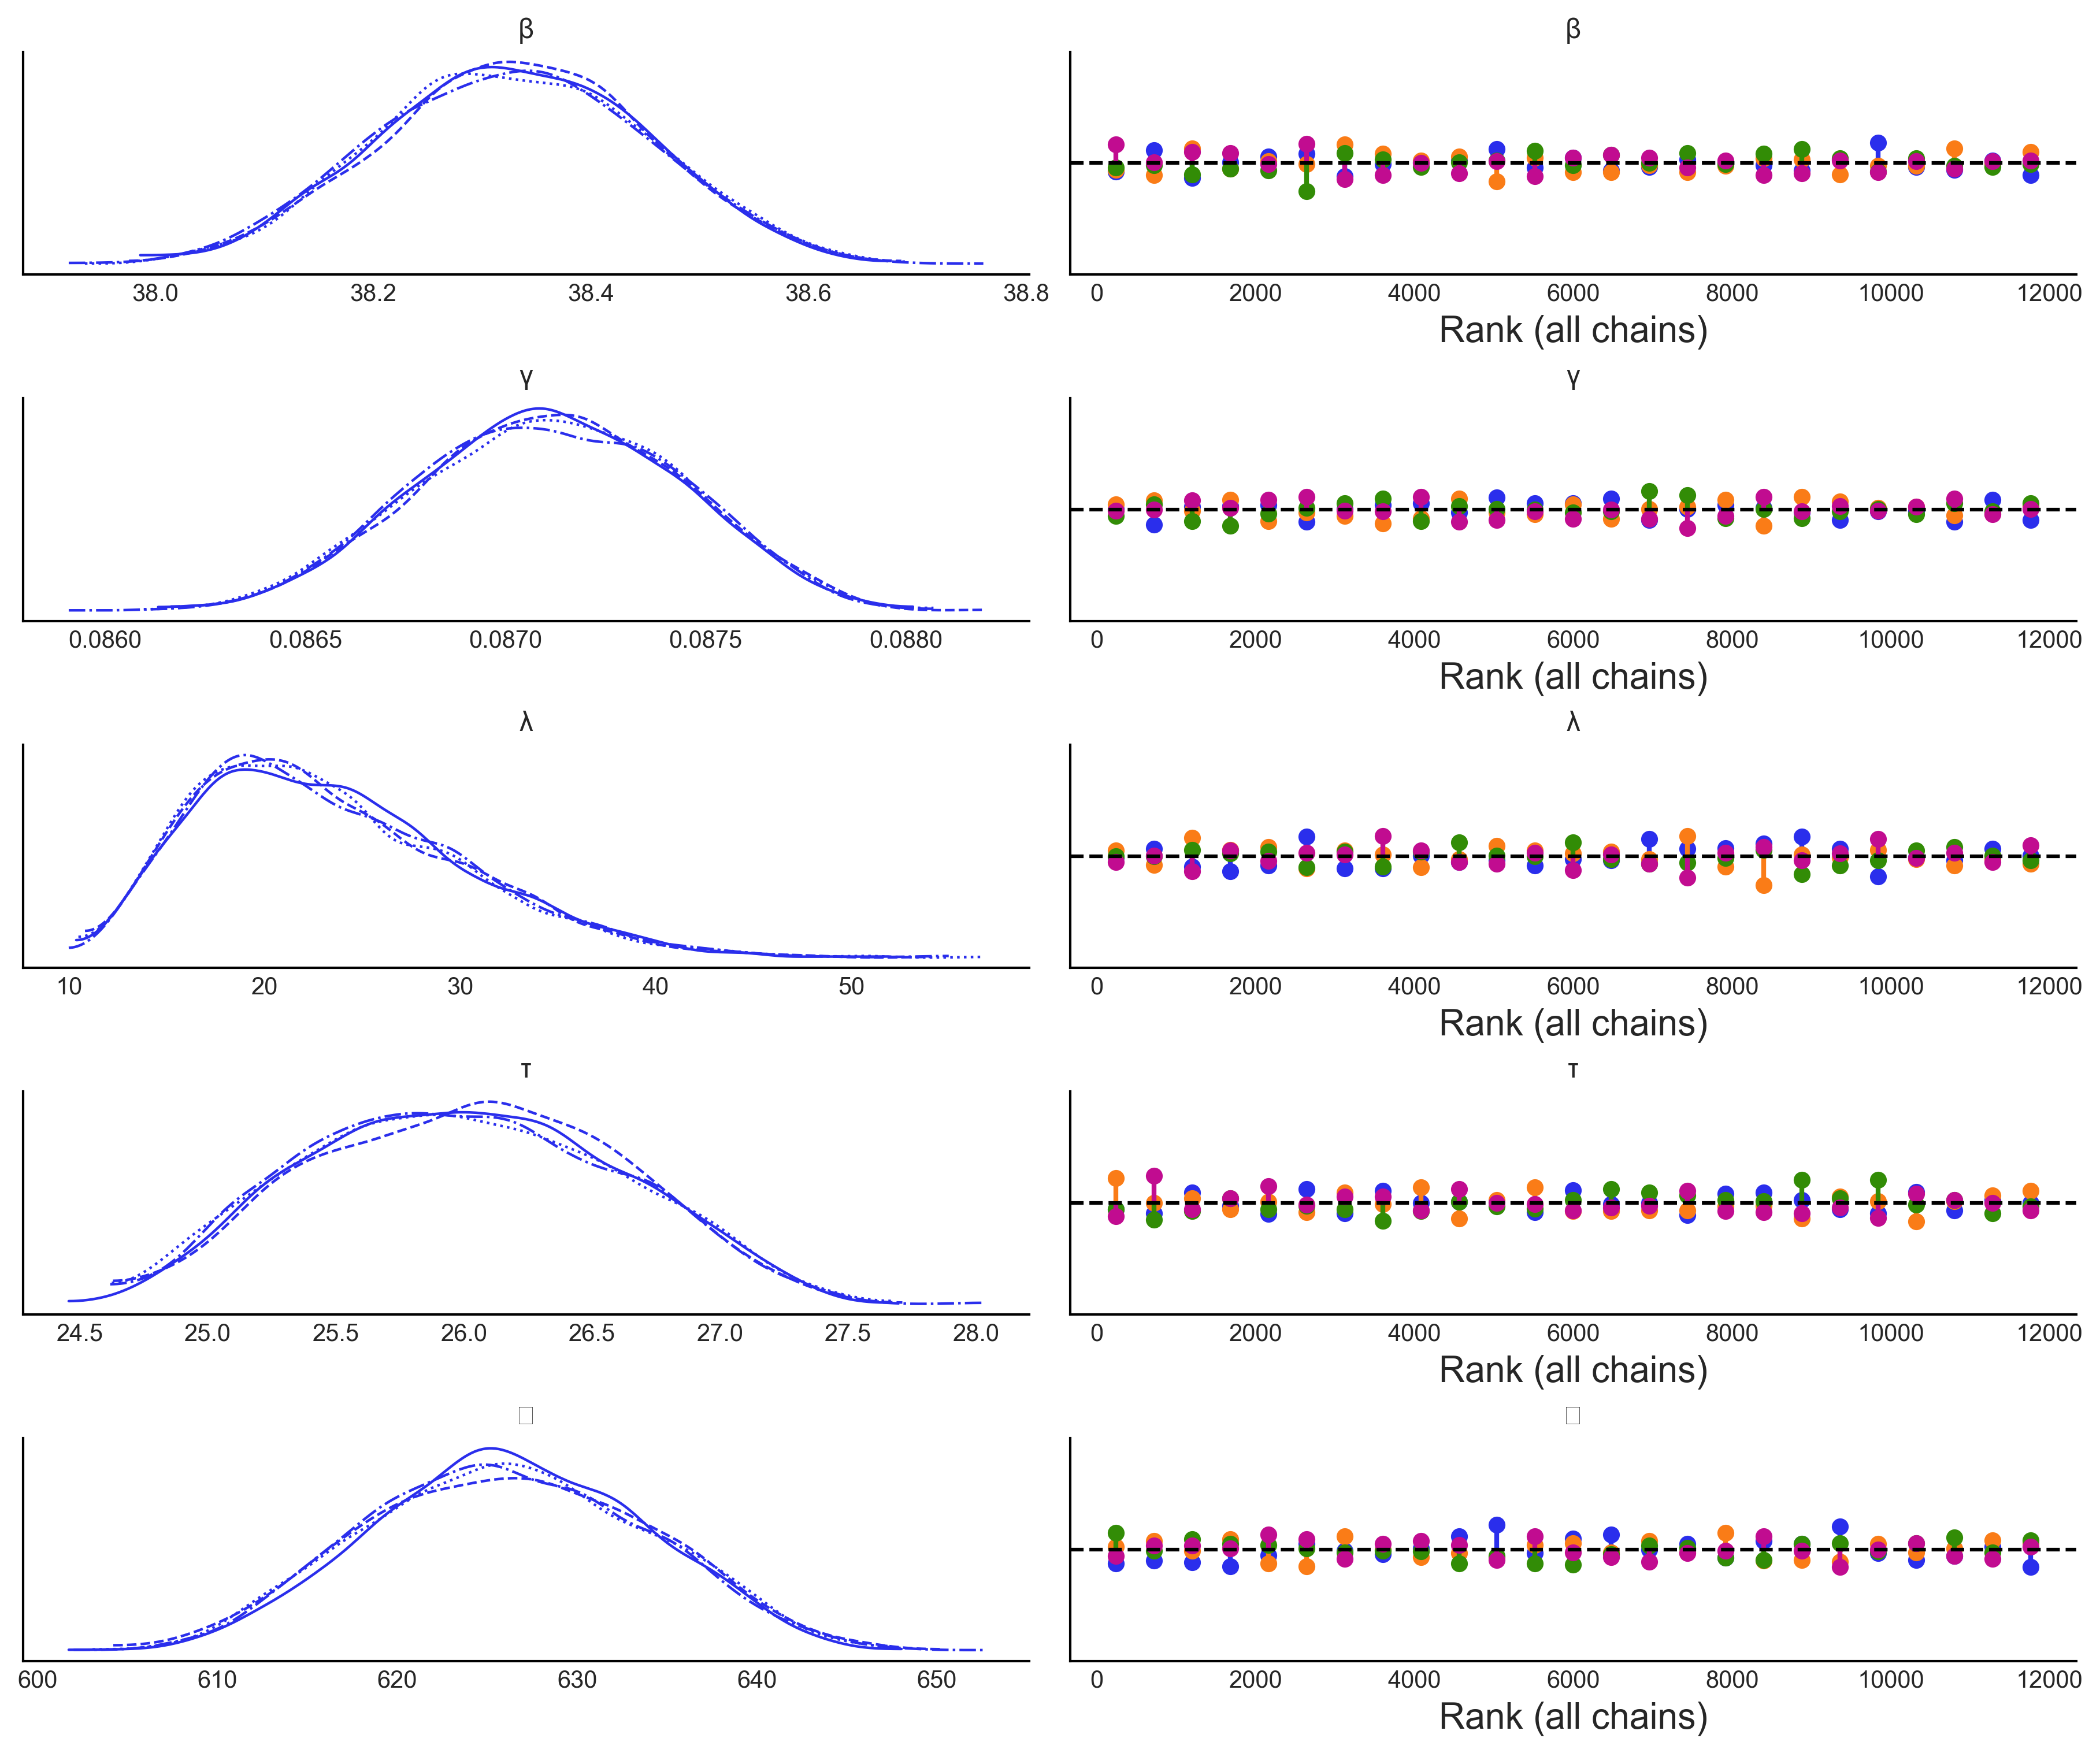

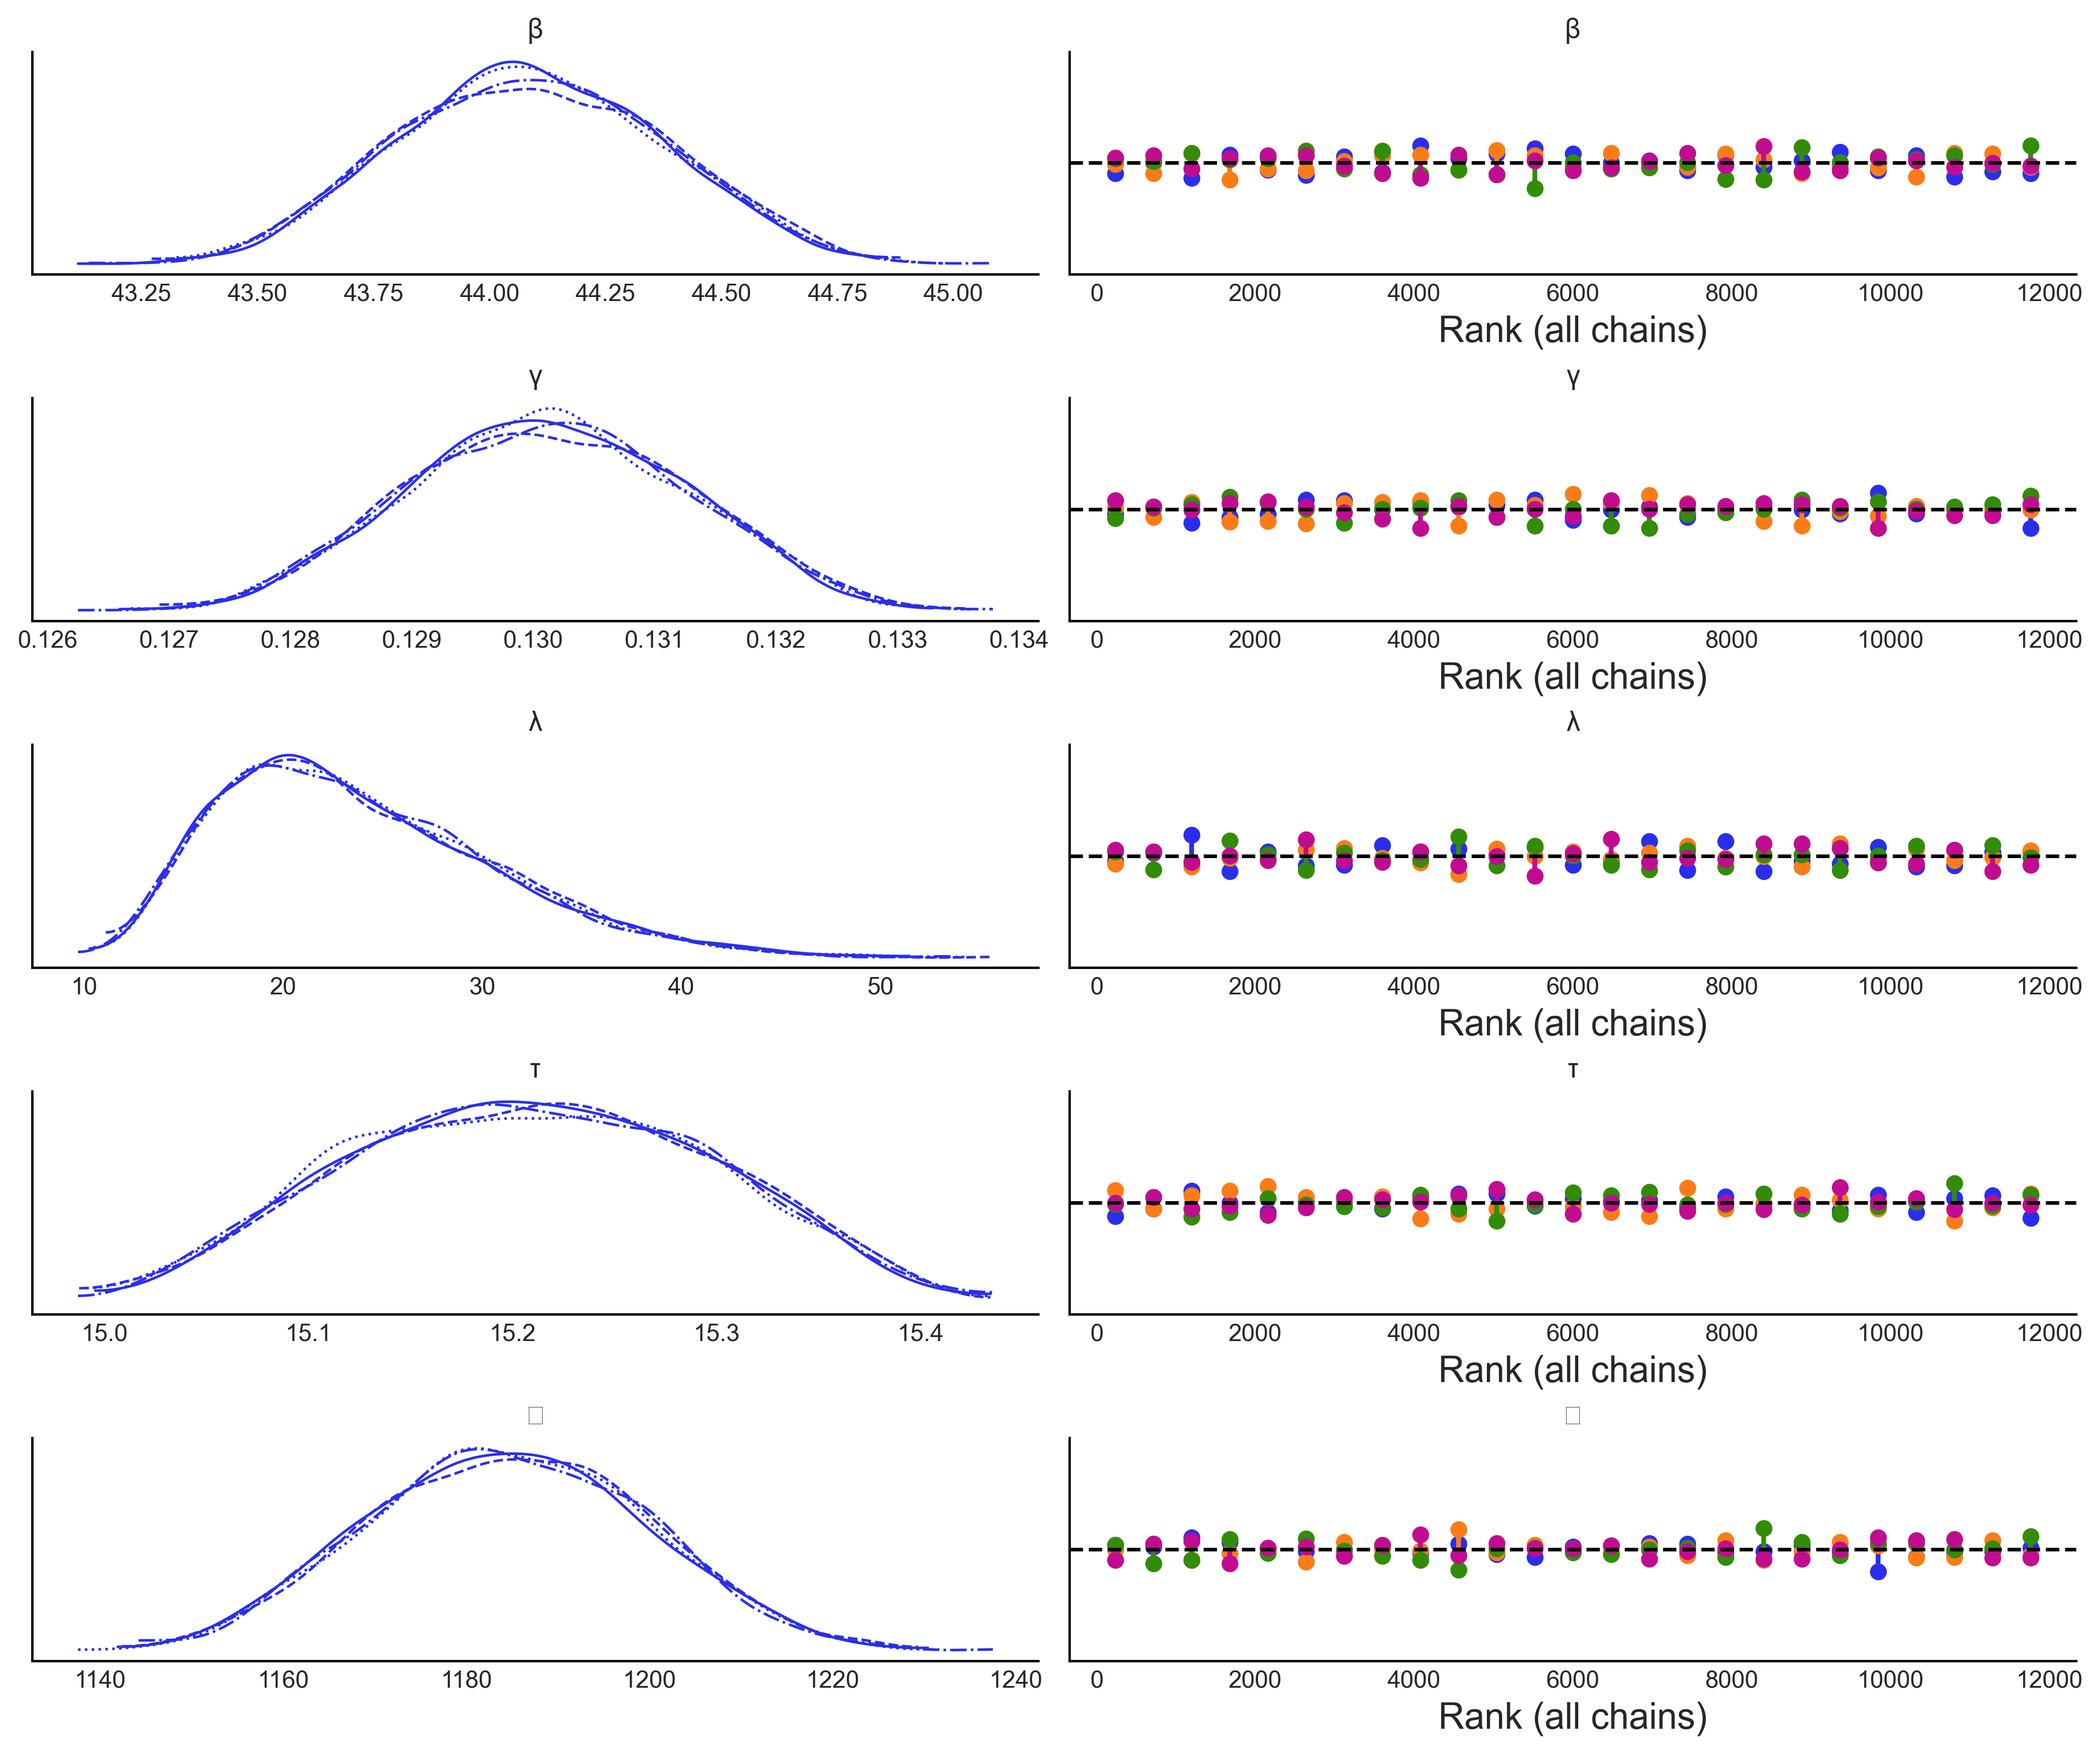

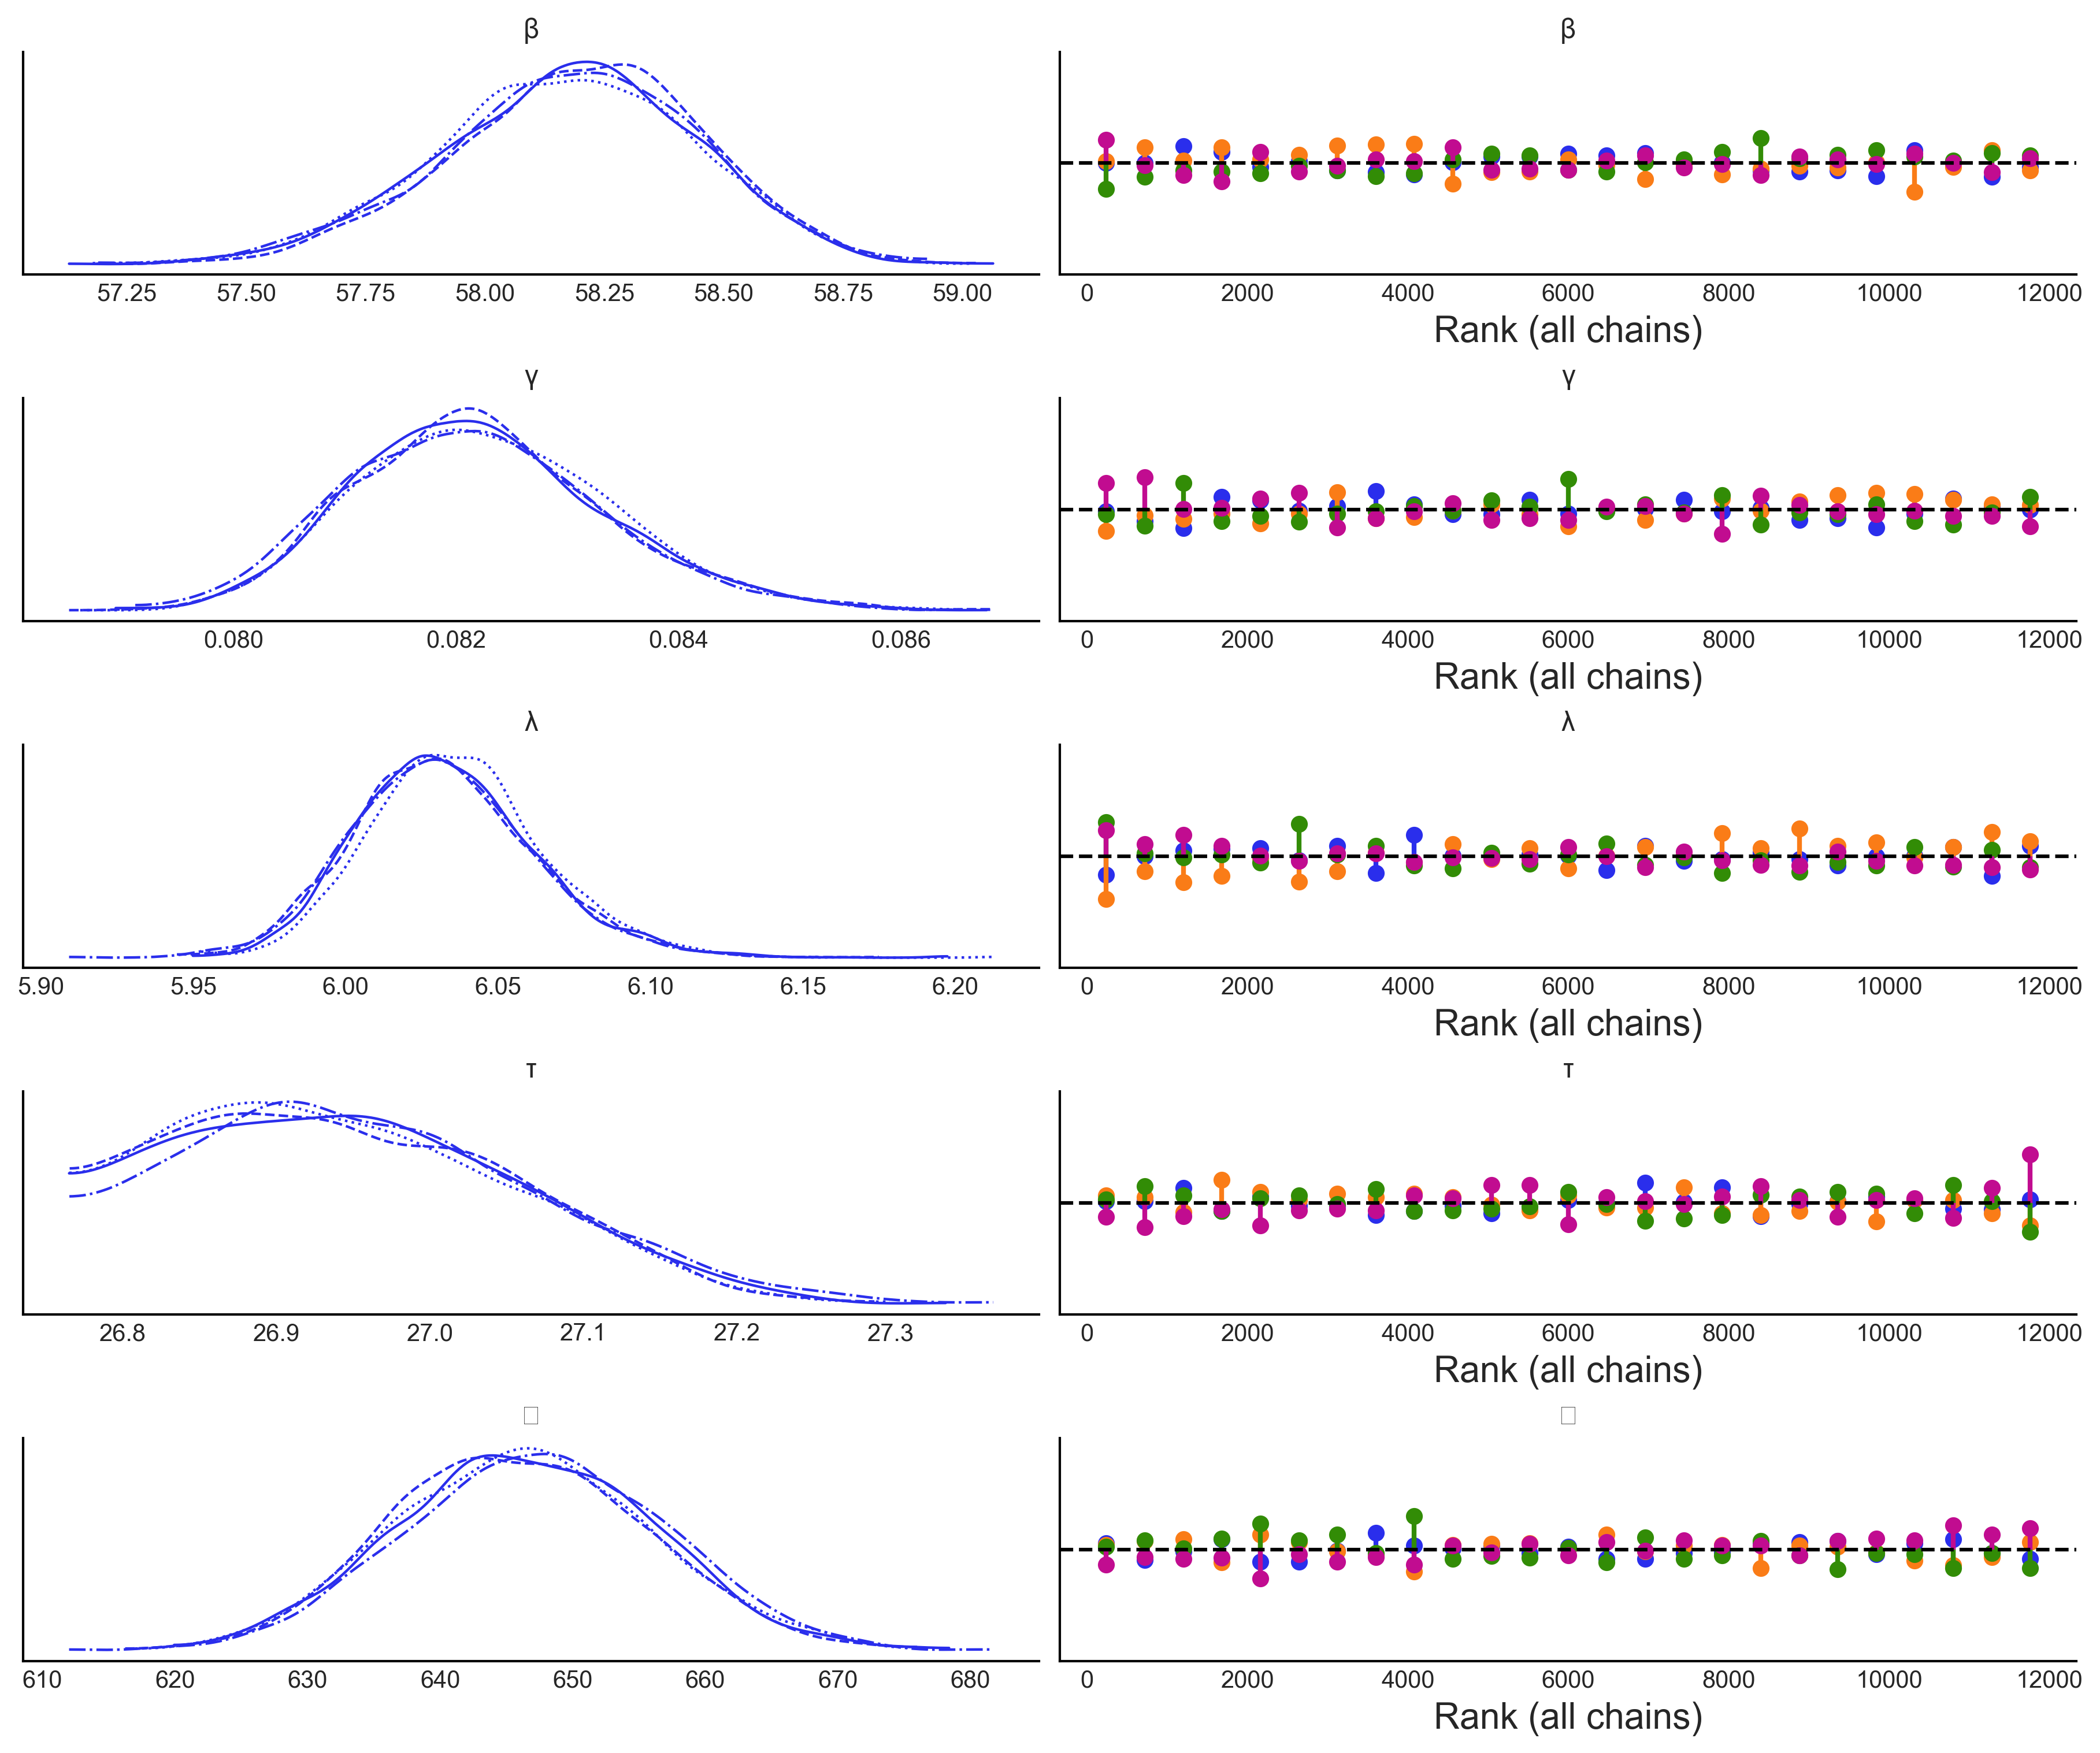

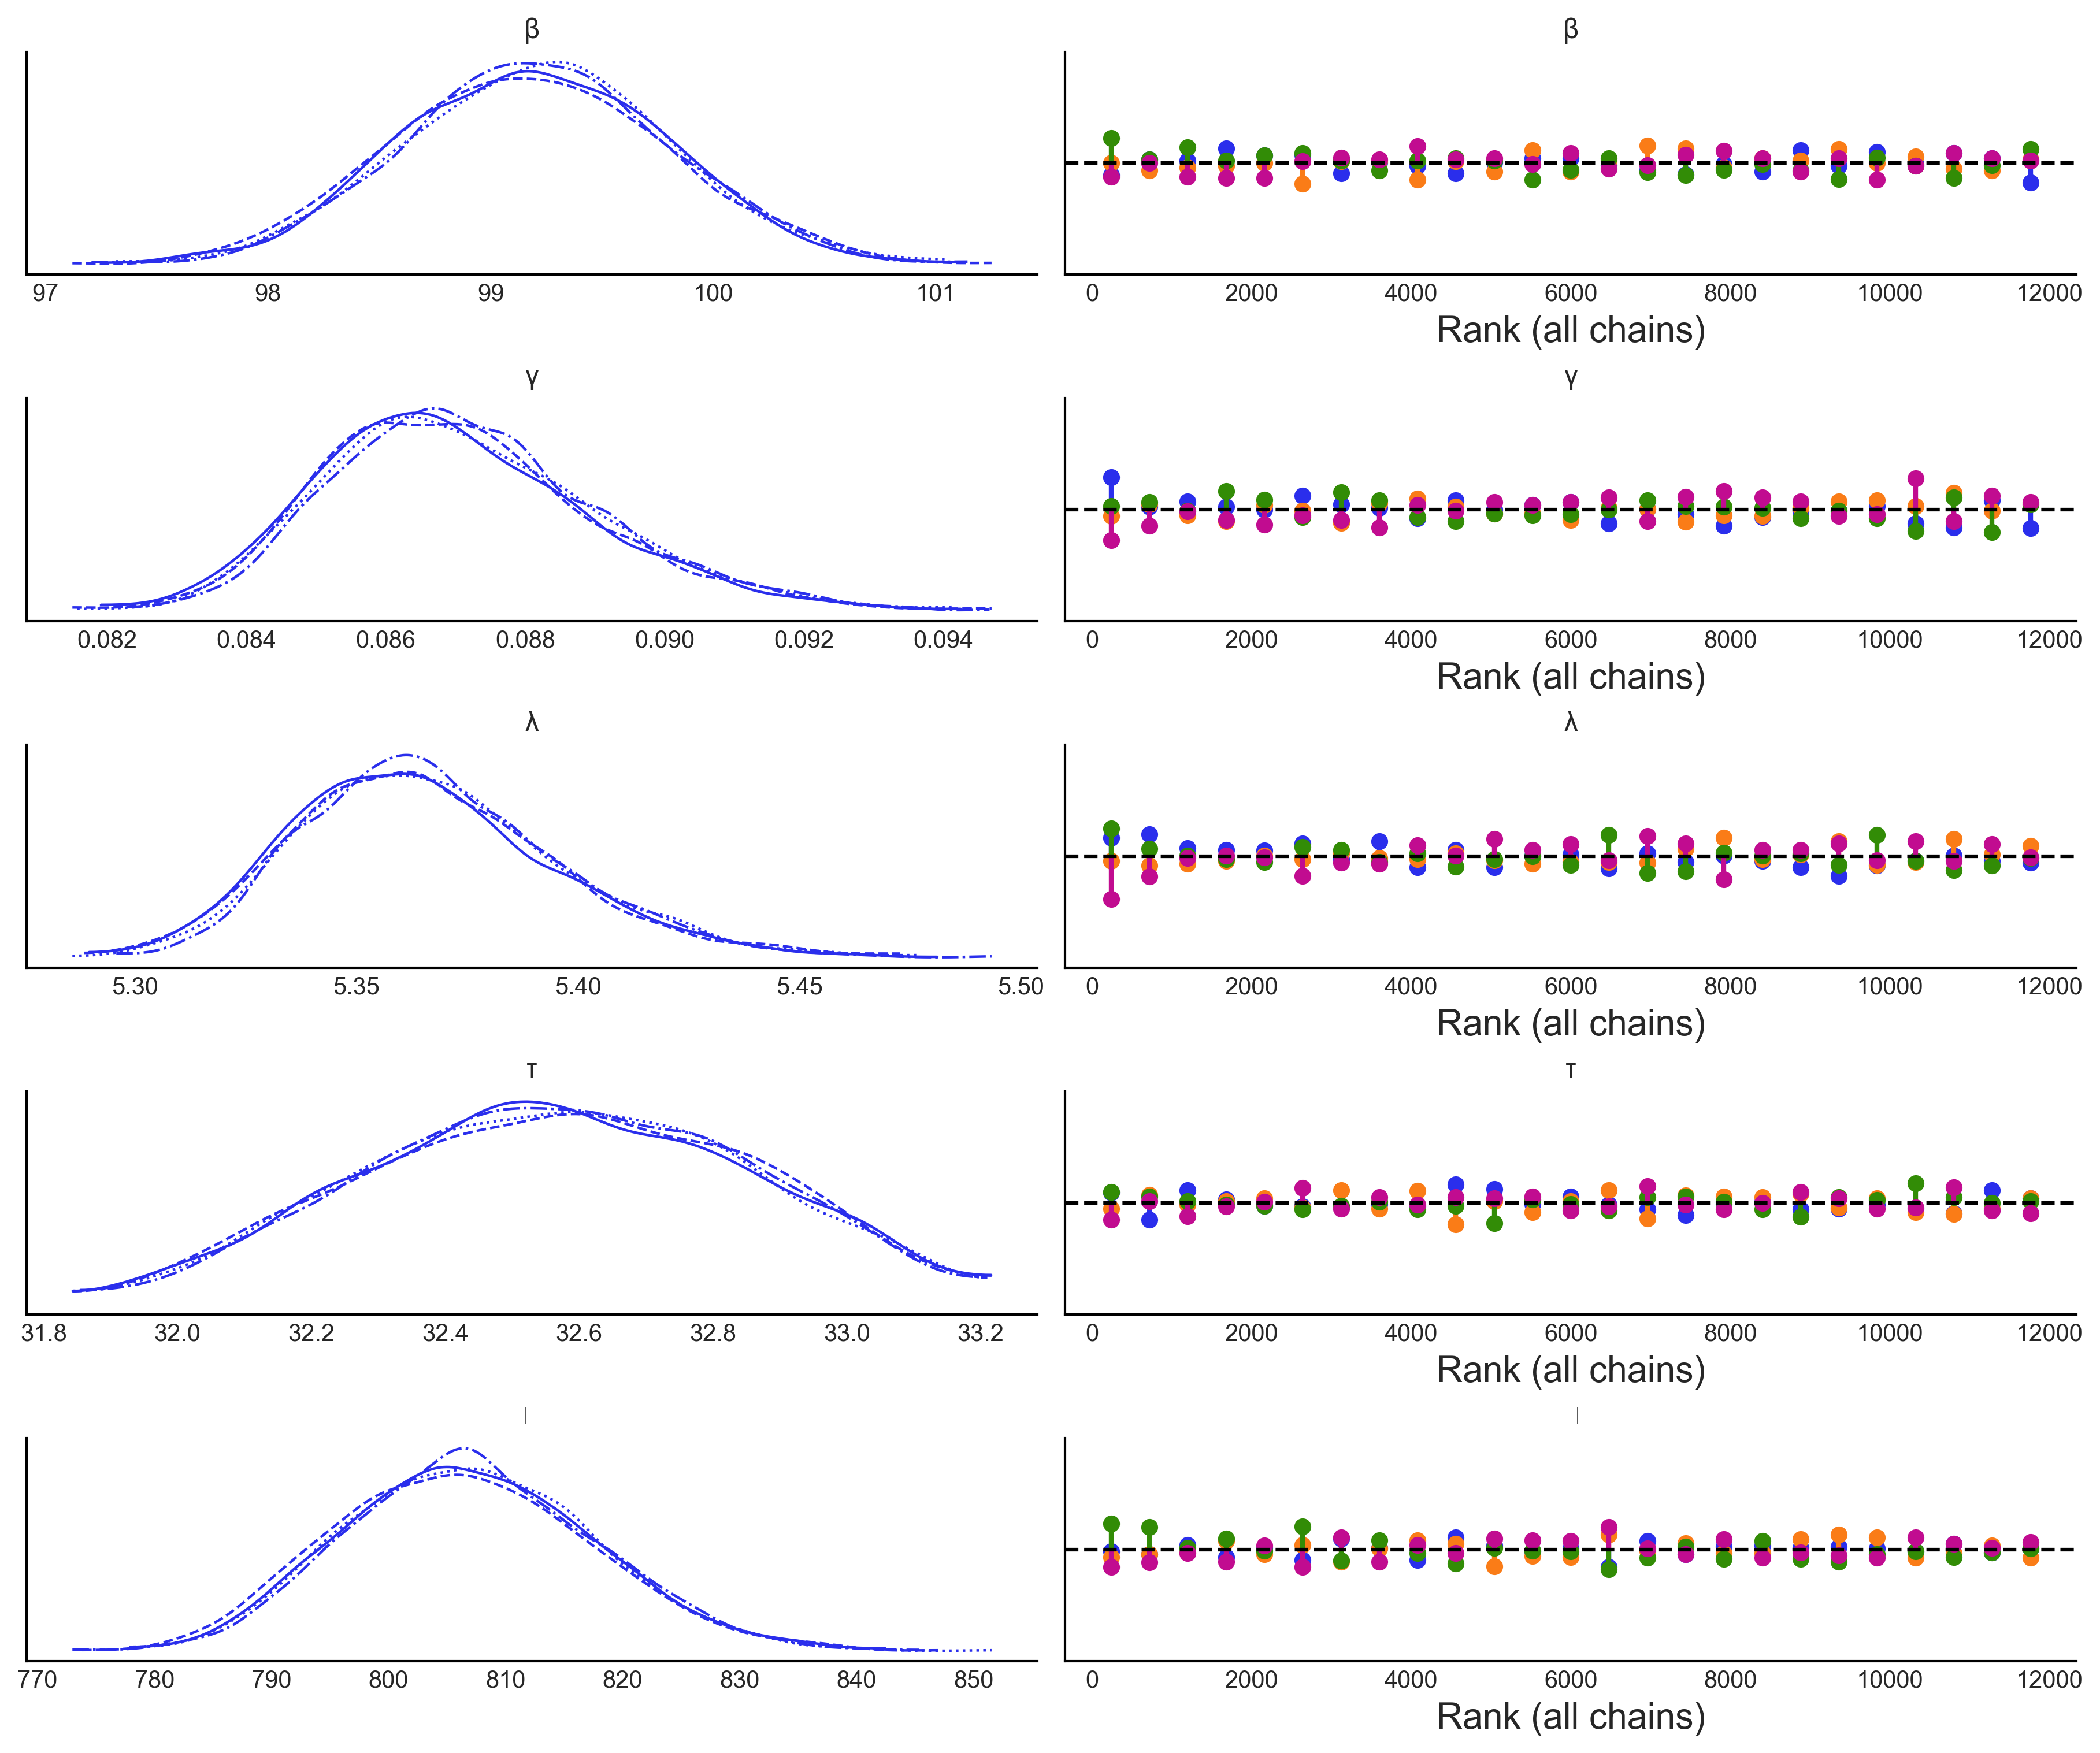

In [6]:
for name in names:  
    az.plot_trace(idatas[name], kind="rank_vlines");

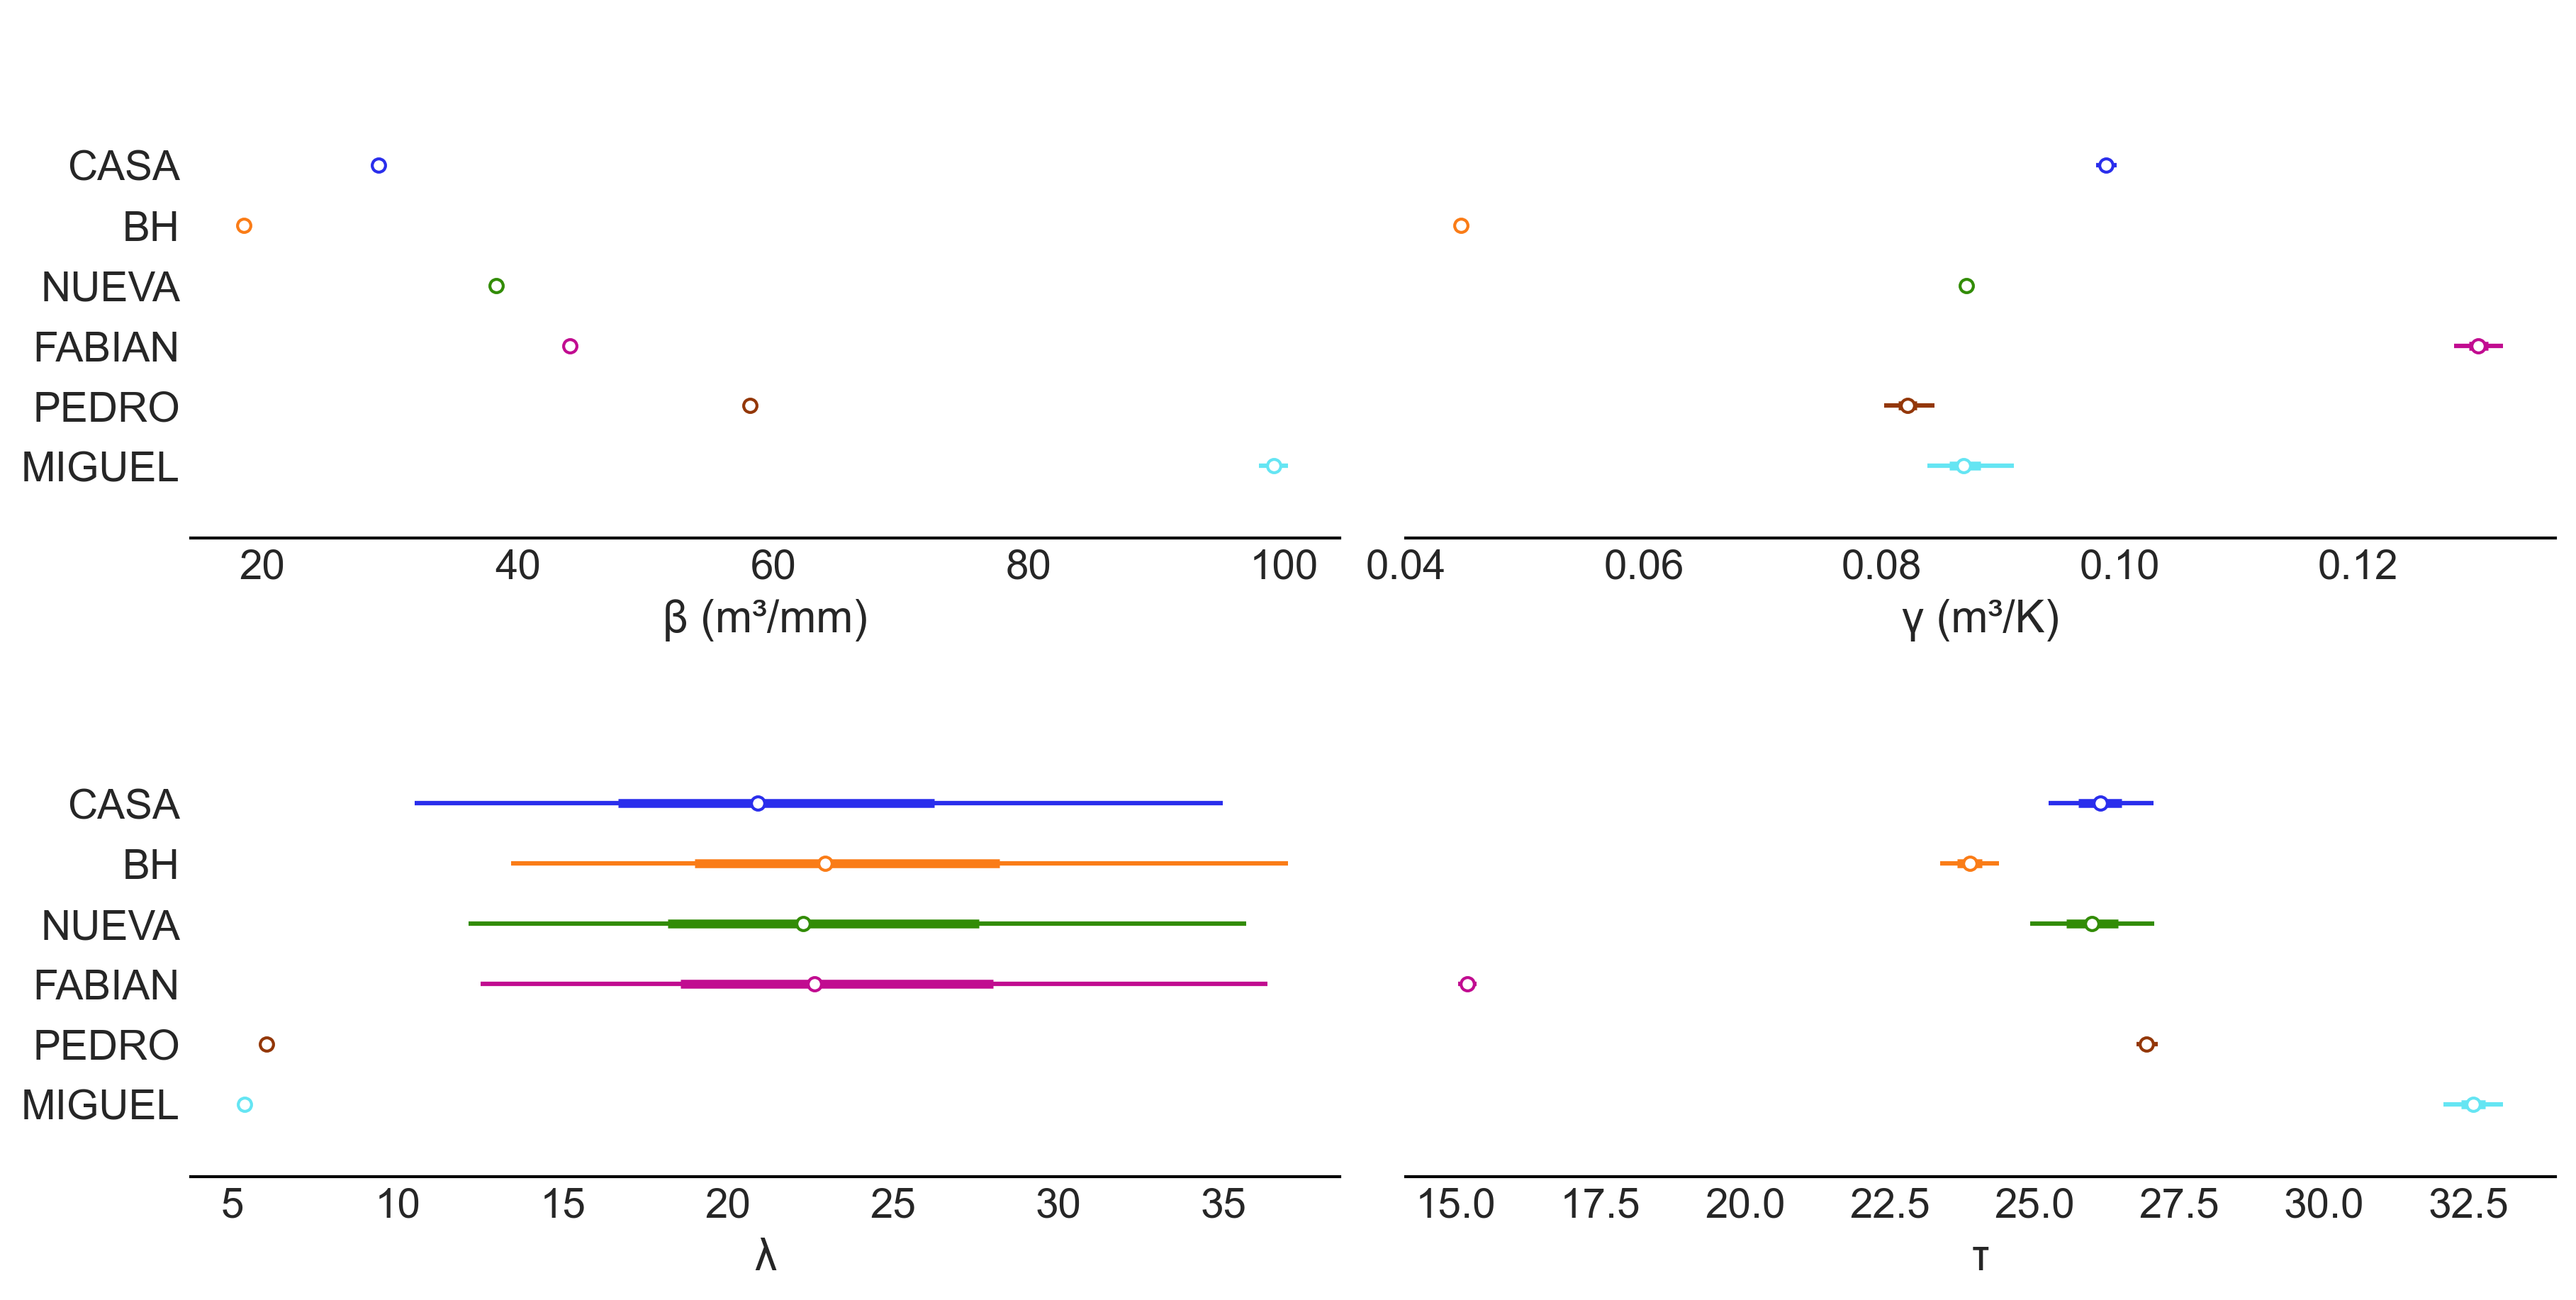

In [7]:
var_names = ["β", "γ", "λ", "τ"]
units = [" (m³/mm)", " (m³/K)", "", ""]  
        

_, axes = plt.subplots(2, 2, figsize=(12, 6), sharey=True)
for ax, var, unit in zip(axes.ravel(), var_names, units):
    az.plot_forest(list(idatas.values()), model_names=names, var_names=var, combined=True,
                   ax=ax, legend=False)
    ax.set_ylabel("")
    ax.set_title("")
    ax.set_xlabel(var + unit)

for ax in axes.ravel():
    if ax.get_yticklabels():
        new_labels = [ax.get_yticklabels()[i]._text.split(":")[0] for i in range(len(names))]
        ax.set_yticklabels(new_labels)

        
plt.savefig("physical_model_params.png")

In [8]:
for k, v in idatas.items():
    print(k)
    print(az.summary(v, kind="stats"))

CASA
      mean     sd   hdi_3%  hdi_97%
β   29.107  0.109   28.901   29.302
γ    0.099  0.000    0.098    0.100
λ   21.969  7.043   10.517   34.998
τ   26.138  0.500   25.242   27.053
ϵ  566.066  6.685  554.009  578.730
BH
      mean     sd   hdi_3%  hdi_97%
β   18.556  0.053   18.457   18.655
γ    0.045  0.000    0.044    0.045
λ   24.044  6.740   13.431   36.956
τ   23.879  0.284   23.373   24.384
ϵ  297.748  3.424  291.513  304.101
NUEVA
      mean     sd   hdi_3%  hdi_97%
β   38.329  0.122   38.103   38.558
γ    0.087  0.000    0.087    0.088
λ   23.329  6.764   12.146   35.691
τ   25.998  0.598   24.926   27.071
ϵ  626.137  7.722  611.915  640.004
FABIAN
       mean      sd    hdi_3%   hdi_97%
β    44.088   0.286    43.576    44.622
γ     0.130   0.001     0.128     0.132
λ    23.761   6.867    12.511    36.349
τ    15.209   0.089    15.046    15.366
ϵ  1184.535  15.034  1156.357  1211.703
PEDRO
      mean     sd   hdi_3%  hdi_97%
β   58.179  0.267   57.671   58.669
γ    0.082  0

In [9]:
for name in names:
    idata = idatas[name]
    pp = pm.sample_posterior_predictive(idata, model=models[name], random_seed=2045)
    idata.extend(pp)

Sampling: [y_obs]


Sampling: [y_obs]


Sampling: [y_obs]


Sampling: [y_obs]


Sampling: [y_obs]


Sampling: [y_obs]


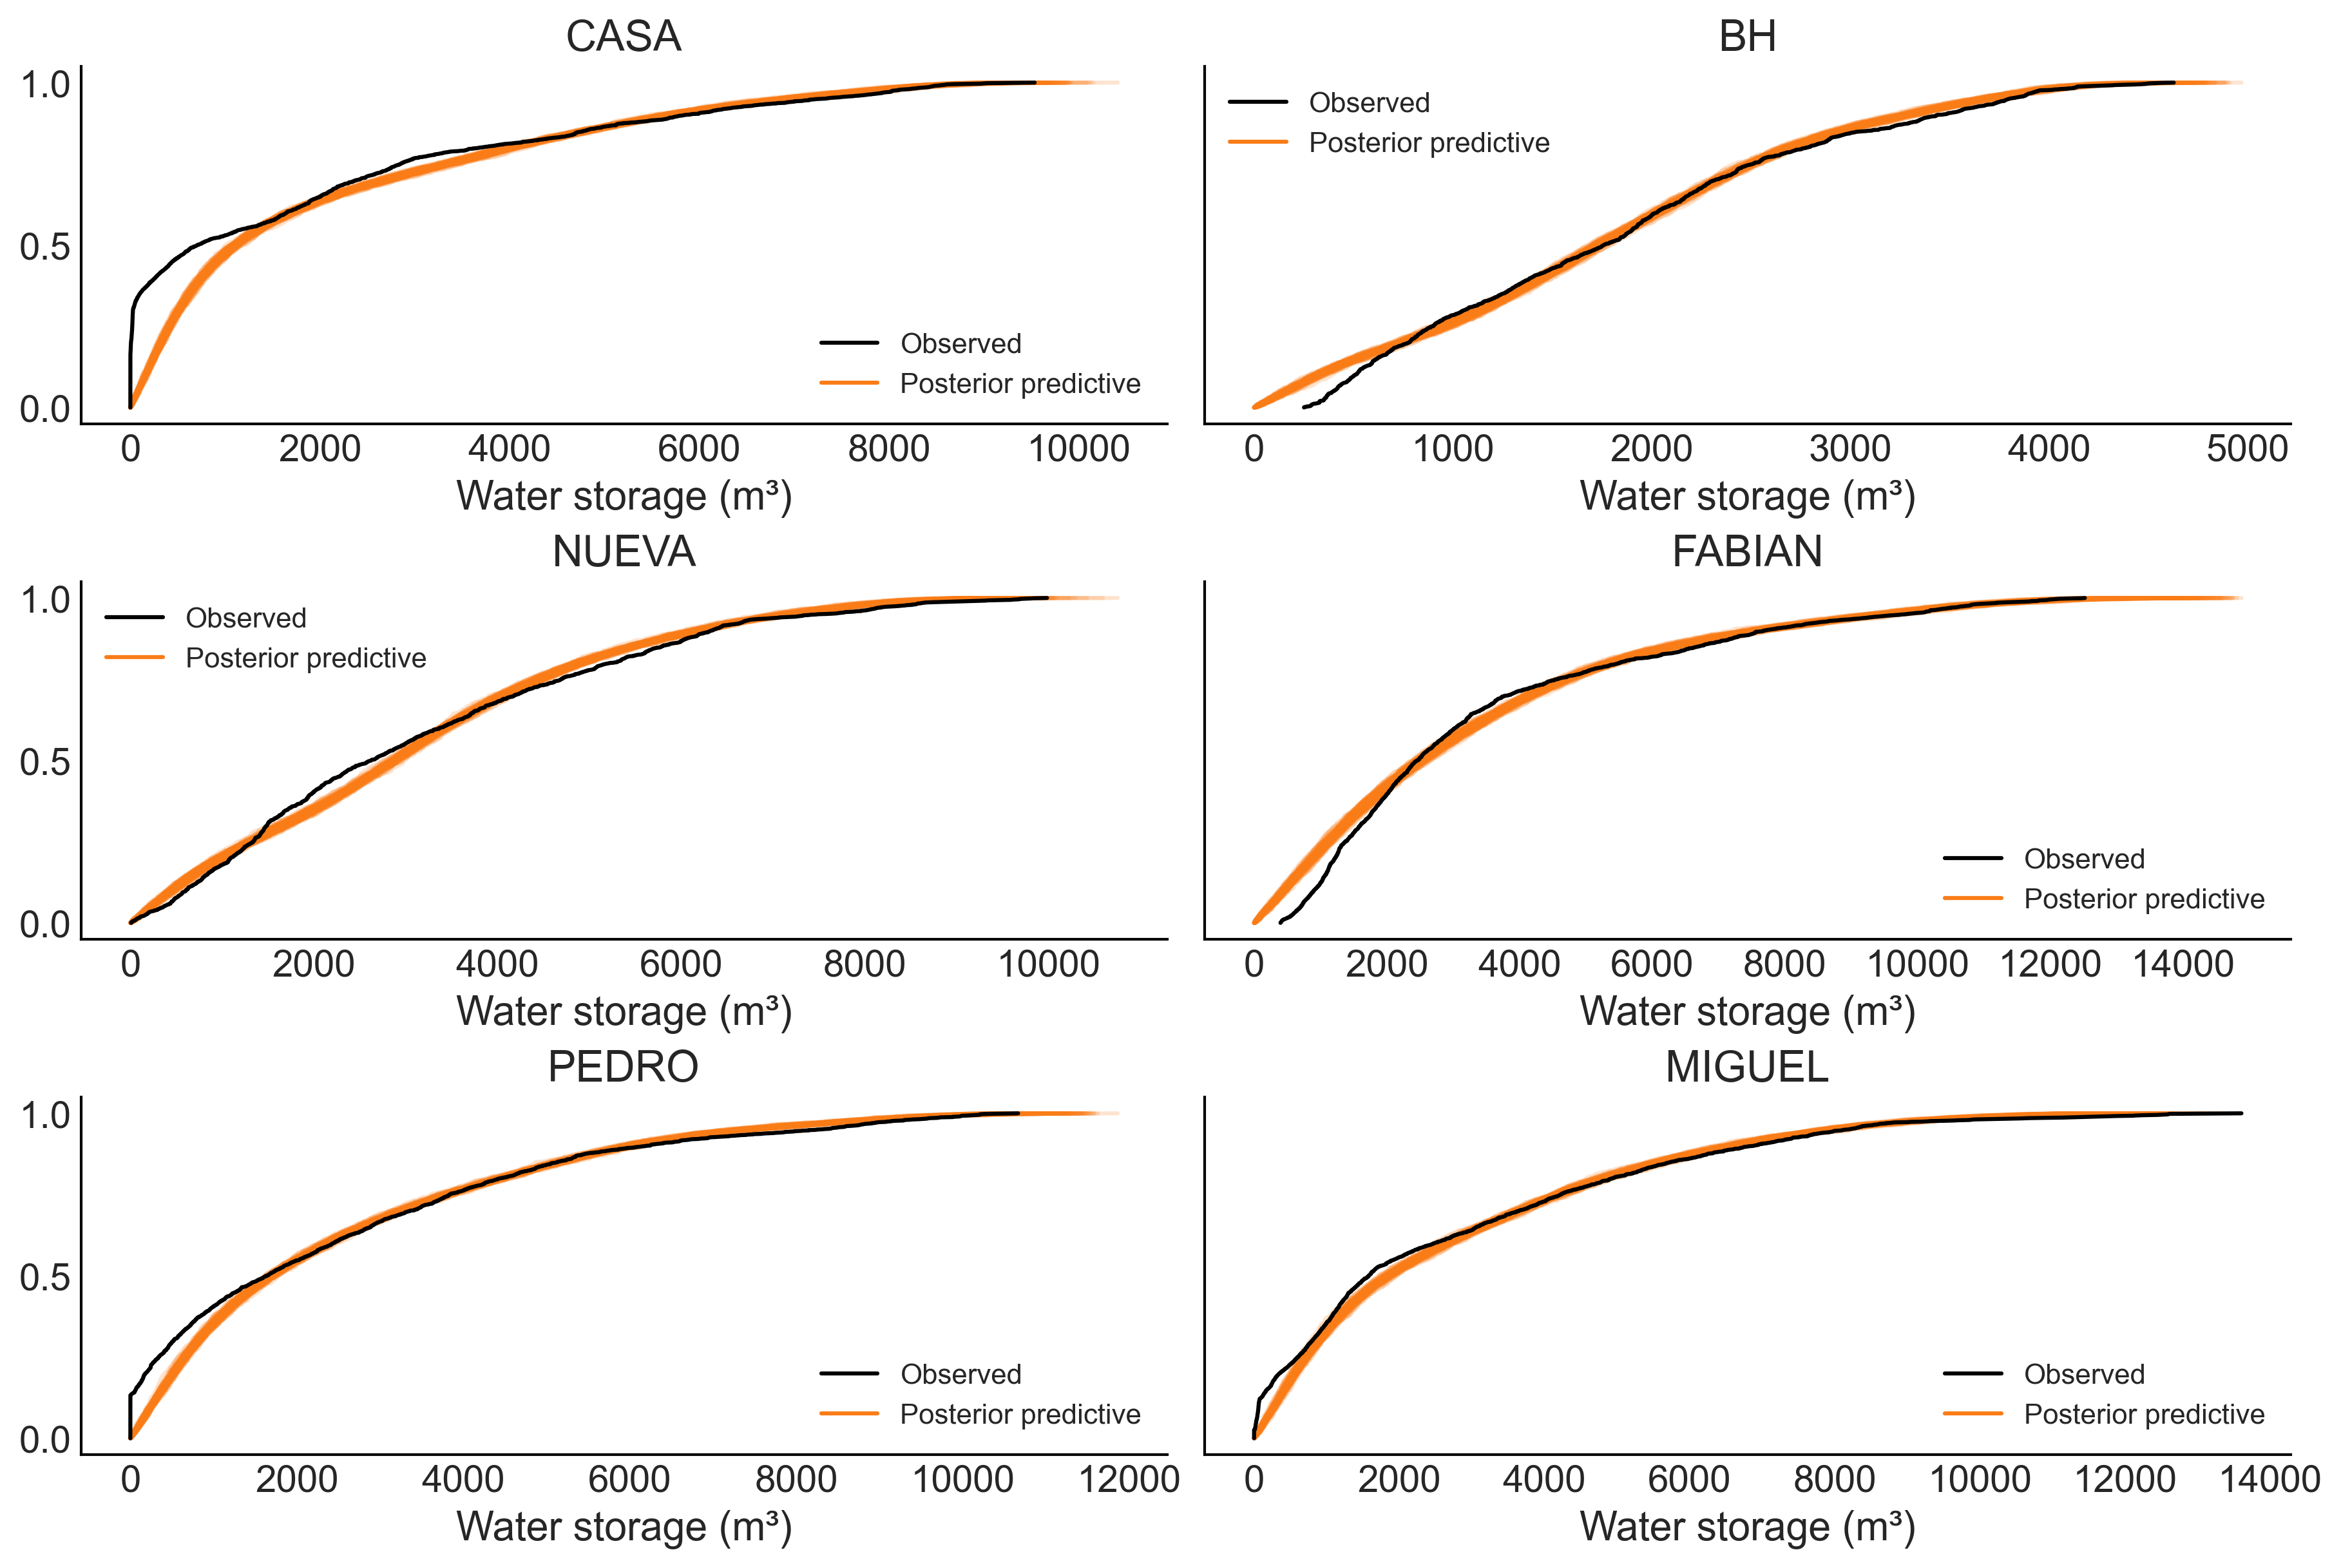

In [10]:
_, axes = plt.subplots(3, 2, sharey=True, figsize=(12, 8))
for name, ax in zip(names, axes.ravel()):
    az.plot_ppc(idatas[name], num_pp_samples=100, kind="cumulative", mean=False, colors=["C1", "k", None], ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Water storage (m³)")
plt.savefig("physical_model_ppc_cumulative.png")

In [11]:
def sim(rng, λ, τ, β, γ, ϵ, size=None):
    mean_vols = p_model(λ, τ, β, γ)
    return pz.TruncatedNormal(mu=mean_vols, sigma=ϵ, lower=0, upper=np.inf).rvs()


def p_model(λ, τ, β, γ):
    prev = vol[0]
    vols = np.zeros_like(vol)
    vols[0] = prev
    for i in range(1, len(vol)):
        if (rain[i] + rain[i-1]) > τ:
            influx = rain[i] * β
        else:
            influx = 0.
        prev = max(0.0001, (prev - prev*np.exp(-λ) + influx - tma[i] * γ))
        vols[i] = prev
    return vols

/tmp/ipykernel_34032/2794310830.py:34: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi = az.hdi(preds)
/tmp/ipykernel_34032/2794310830.py:34: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi = az.hdi(preds)
/tmp/ipykernel_34032/2794310830.py:34: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi = az.hdi(preds)
/tmp/ipykernel_34032/2794310830.py:34: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi = az.hdi(preds)
/tmp/ipykernel_34032/2794310830.py:34: FutureWarning: hdi currently interprets 2d data as (draw, shape) 

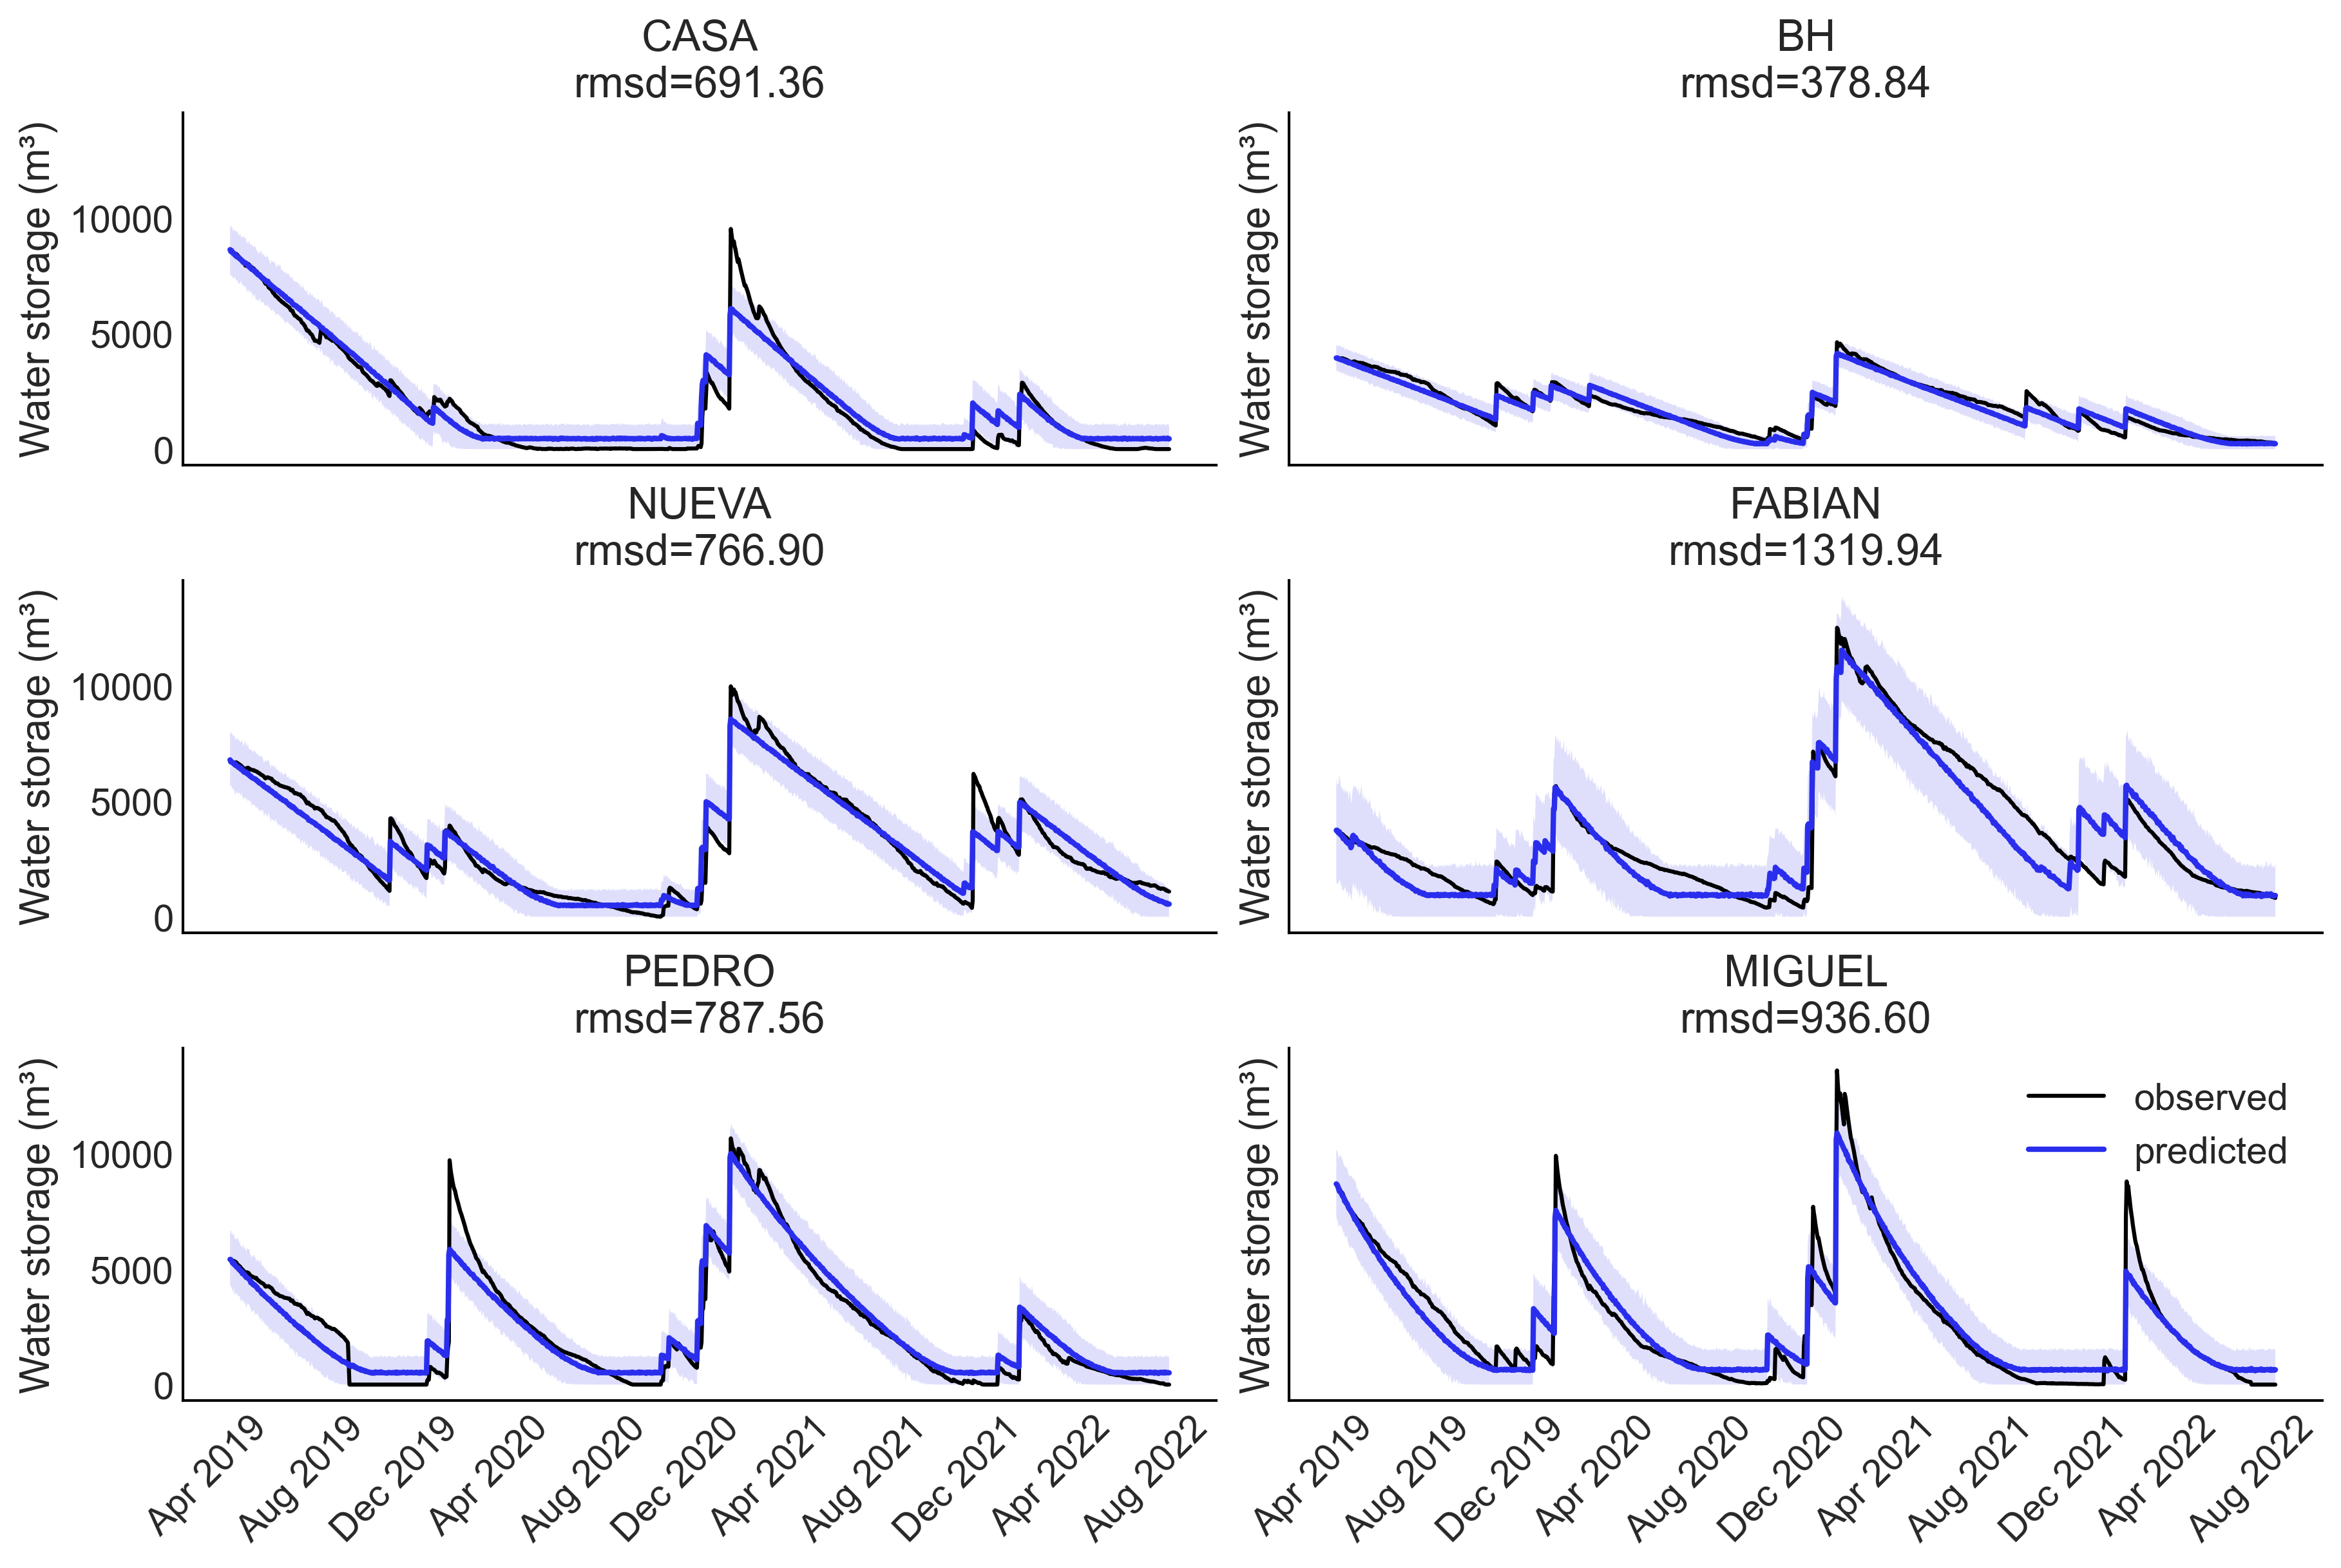

In [12]:
_, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 8))
for name, ax in zip(names, axes.ravel()):
    #posterior = az.extract(idatas[name], num_samples=5000)
    posterior = az.extract(idatas[name], num_samples=1000)

    λs = posterior["λ"]
    τs = posterior["τ"]
    βs = posterior["β"]
    γs = posterior["γ"]
    ϵs = posterior["ϵ"]

    df = pd.read_excel("19-22_DataModelo_v3.xlsx", sheet_name=name)

    time = df['Fecha'].values
    rain = df[f'SumaDifPluvio(mm)_{str.title(name)}'].values
    vol = df[f"VolumenRep{str.title(name)}_m3"].values
    tma = df['TempMediaAire_Celsius'].values + 273.15

    preds = []
    for λ, τ, β, γ, ϵ in zip(λs, τs, βs, γs, ϵs):
        preds.append(sim(np.random.default_rng(42), λ.item(), τ.item(), β.item(), γ.item(), ϵ.item()))
    preds = np.array(preds)
    rmsd = np.sqrt(np.mean((preds - vol)**2, 0))
    pred_mean = np.mean(preds, 0)
    pred_median = np.median(preds, 0)
    pred_min = np.min(preds, 0)
    pred_max = np.max(preds, 0)
    pred_01 = np.percentile(preds, 1, 0)
    pred_05 = np.percentile(preds, 5, 0)
    pred_10 = np.percentile(preds, 10, 0)
    pred_99 = np.percentile(preds, 99, 0)
    pred_95 = np.percentile(preds, 95, 0)
    pred_90 = np.percentile(preds, 90, 0)
    pred_hdi = az.hdi(preds)


    ax.plot(times[name], vols[name], "k", label="observed")
    ax.plot(times[name], pred_mean, "C0", lw=2, label="predicted")
    ax.fill_between(times[name], pred_hdi[:,0], pred_hdi[:,1], alpha=0.15, color="C0", edgecolor=None)
    ax.set_ylabel("Water storage (m³)")
    ax.set_title(f"{name}\nrmsd={rmsd.mean():.2f}")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[4, 8, 12]))
    ax.tick_params(axis='x', rotation=45)
    pd.DataFrame({"mean": pred_mean,
                  "median":pred_median,
                  "min": pred_min,
                  "max": pred_max,
                  "01": pred_01,
                  "05": pred_05,
                  "10": pred_10,
                  "99": pred_99,
                  "95": pred_95,
                  "90": pred_90,
                  }).to_csv(f"simulated_{name}_05.csv", index=False)
plt.legend();
plt.savefig("physical_model_fit.png")

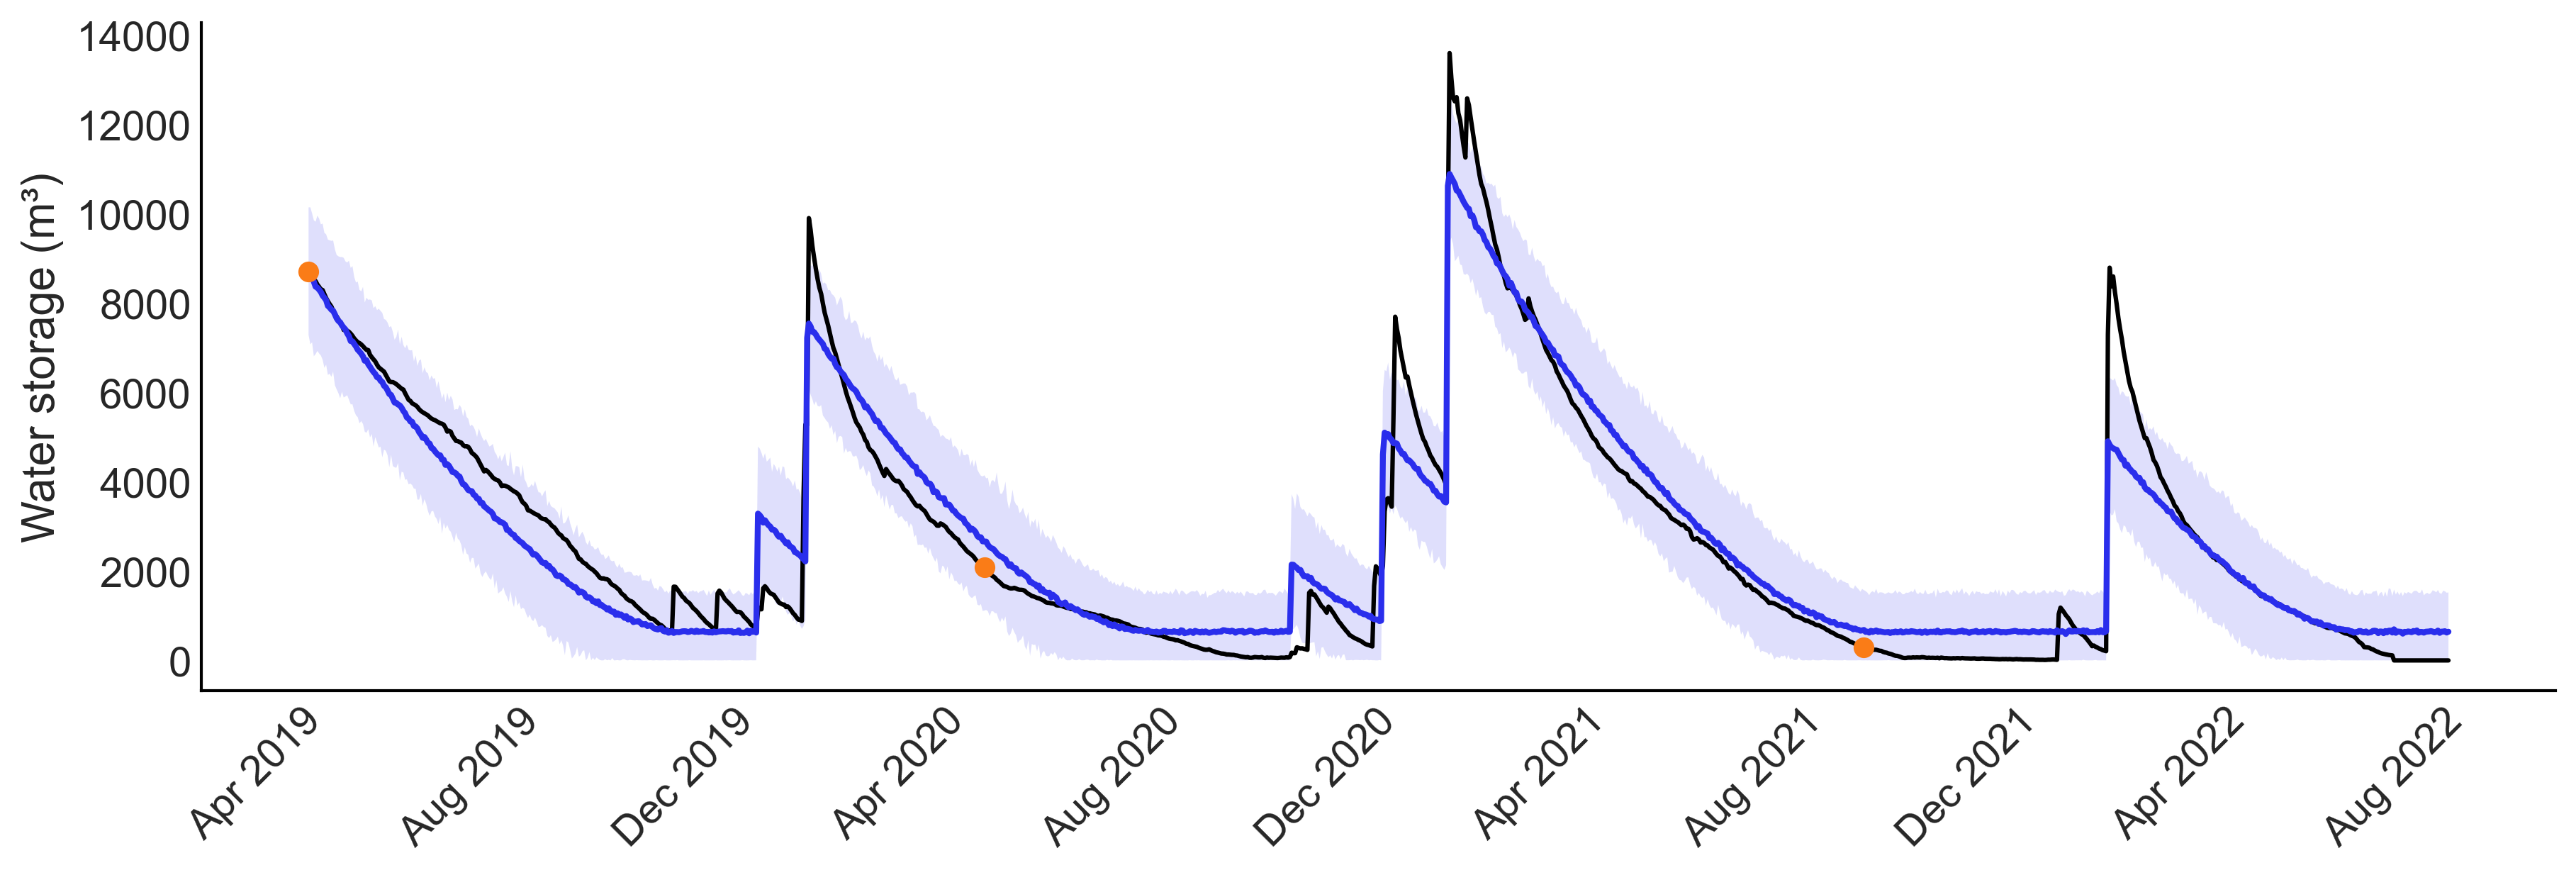

In [16]:
_, ax = plt.subplots(figsize=(12, 4))
name = "MIGUEL"
posterior = az.extract(idatas[name], num_samples=1000)

λs = posterior["λ"]
τs = posterior["τ"]
βs = posterior["β"]
γs = posterior["γ"]
ϵs = posterior["ϵ"]

df = pd.read_excel("19-22_DataModelo_v3.xlsx", sheet_name=name)

time = df['Fecha'].values
rain = df[f'SumaDifPluvio(mm)_{str.title(name)}'].values
vol = df[f"VolumenRep{str.title(name)}_m3"].values
tma = df['TempMediaAire_Celsius'].values + 273.15

preds = []
for λ, τ, β, γ, ϵ in zip(λs, τs, βs, γs, ϵs):
    preds.append(sim(np.random.default_rng(42), λ.item(), τ.item(), β.item(), γ.item(), ϵ.item()))
preds = np.array(preds)

target = ["2019-05-01", "2020-05-20", "2021-10-03"]
values = df.loc[df['Fecha'].isin(target), [f"VolumenRep{str.title(name)}_m3", "Fecha"]]
ax.plot(values['Fecha'], values[f"VolumenRep{str.title(name)}_m3"], "C1o", zorder=3)


ax.plot(times[name], vols[name], "k")
ax.plot(times[name], pred_mean, "C0", lw=2)
ax.fill_between(times[name], pred_hdi[:,0], pred_hdi[:,1], alpha=0.15, color="C0", edgecolor=None)
ax.set_ylabel("Water storage (m³)")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[4, 8, 12]))
ax.tick_params(axis='x', rotation=45)
plt.savefig("physical_model_fit_miguel.png")

In [14]:
%load_ext watermark

In [15]:
%watermark -iv

pymc      : 5.1.2
numpy     : 1.23.5
pytensor  : 2.10.1
matplotlib: 3.5.2
arviz     : 0.16.0.dev0
pandas    : 1.5.3
preliz    : 0.2.0

